# Import modules

In [1]:
import csv
import os
import pickle
import pytz
import torch
import timeit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from copy import deepcopy
from datetime import datetime
from einops import rearrange
from itertools import chain
from time import time
from torch import nn, optim
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score, MulticlassConfusionMatrix
from torch.optim import lr_scheduler
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader
from polyglot.mapping import Embedding, CaseExpander, DigitExpander

# Hyperparameters

In [2]:
class Hyperparams:
     def __init__(
        self,
        context_size=70,
        fold=5,
        max_seq_len=82,
        input_size=64,
        batch_size=32,
        num_hidden_layer=1,
        hidden_size=128,
        dropout=0,
        bias=True,
        output_size=24,
        shuffle=True,
        lr=0.005,
        batch_first=False,
        bidirectional=True,
        init_wb_with_kaiming_normal=True,
        n_epoch=50,
        patience=50,
        device="cuda" if torch.cuda.is_available() else "cpu"
    ):
        self.context_size = context_size
        self.fold = fold
        self.input_size = input_size
        self.max_seq_len = max_seq_len
        self.batch_size = batch_size
        self.num_hidden_layer = num_hidden_layer
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.output_size = output_size
        self.shuffle = shuffle
        self.lr = lr
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        self.init_wb_with_kaiming_normal = init_wb_with_kaiming_normal
        self.n_epoch = n_epoch
        self.patience = patience
        self.device = device

hyperparams = Hyperparams()

# Dataset

In [3]:
id_pos_tag = pd.read_csv("../../../datasets/raw/Indonesian_Manually_Tagged_Corpus.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False) 
train = pd.read_csv(f"../../../datasets/raw/cv/train/train.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
val = pd.read_csv(f"../../../datasets/raw/cv/val/val.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
test = pd.read_csv(f"../../../datasets/raw/cv/test/test.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)

# Pre-trained Word Embedding

In [4]:
embeddings = Embedding.load("../../../word_embeddings/polyglot/idn_embeddings.tar.bz2")
embeddings.apply_expansion(DigitExpander)
embeddings.apply_expansion(CaseExpander)

oov_embeddings = pickle.load(open(f"../../../logs/comick/{hyperparams.context_size}_contexts/10-11-2022_18-03-50/oov_embedding_dict.pkl", "rb"))

# Data Preprocessing

## Add OOV Flag

In [5]:
def add_oov_flag(tokens, embeddings):
    oov_flags = []
    
    for token in tqdm(tokens):
        try:
            if token not in embeddings:
                oov_flags.append(True)
            else:
                oov_flags.append(False)
        except:
            oov_flags.append(False)
        
    return pd.DataFrame(oov_flags, columns=["is_oov"])

id_pos_tag_oov_flags = add_oov_flag(id_pos_tag["token"].values, embeddings)
train_oov_flags = add_oov_flag(train["token"].values, embeddings)
val_oov_flags = add_oov_flag(val["token"].values, embeddings)
test_oov_flags = add_oov_flag(test["token"].values, embeddings)

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/191905 [00:00<?, ?it/s]

  0%|          | 0/21691 [00:00<?, ?it/s]

  0%|          | 0/53056 [00:00<?, ?it/s]

## Concate OOV Flag

In [6]:
id_pos_tag_df = pd.concat([id_pos_tag, id_pos_tag_oov_flags], axis=1)
train_df = pd.concat([train, train_oov_flags], axis=1)
val_df = pd.concat([val, val_oov_flags], axis=1)
test_df = pd.concat([test, test_oov_flags], axis=1)

## Lowercase OOV Token

In [7]:
id_pos_tag_df['token'] = np.where(id_pos_tag_df['is_oov'] == True, id_pos_tag_df['token'].str.lower(), id_pos_tag_df['token'])
train_df['token'] = np.where(train_df['is_oov'] == True, train_df['token'].str.lower(), train_df['token'])
val_df['token'] = np.where(val_df['is_oov'] == True, val_df['token'].str.lower(), val_df['token'])
test_df['token'] = np.where(test_df['is_oov'] == True, test_df['token'].str.lower(), test_df['token'])

## Embedding Dict, Index to Token and Token to Index

In [8]:
tokens = list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None))

def embedding_dict(tokens, embeddings, oov_embeddings):
    embedding = {}
    
    for token in tokens:
        if token[0] is not np.nan:
            if token[2] == False or token[0] in embeddings:
                embedding[token[0]] = embeddings[token[0]]
            else:
                embedding[token[0]] = oov_embeddings[token[0].lower()]

    return embedding

embedding_dict = embedding_dict(tokens, embeddings, oov_embeddings)
embedding_dict["<PAD>"] = embeddings["<PAD>"]
word_embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(embedding_dict.values()))), padding_idx=list(embedding_dict.keys()).index("<PAD>"), freeze=True)

idx_to_token = {idx: token for idx, token in enumerate(list(embedding_dict.keys()))}
token_to_idx = {token: idx for idx, token in enumerate(list(embedding_dict.keys()))}

## Token to Sentence

In [9]:
def make_sentence(tokens, max_length_sentence=hyperparams.max_seq_len):
    sentence = []
    sentences = []

    for token in tqdm(tokens):
        if token[0] is not np.nan:
            sentence.append(token)
        else:
            sentences.append(sentence[:max_length_sentence])
            sentence = []

    return sentences

all_sentence = make_sentence(list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
train_sentences = make_sentence(list(train_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
val_sentences = make_sentence(list(test_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
test_sentences = make_sentence(list(val_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/191905 [00:00<?, ?it/s]

  0%|          | 0/53056 [00:00<?, ?it/s]

  0%|          | 0/21691 [00:00<?, ?it/s]

## Word Token, Padding, and Word token to Index 

In [10]:
def tokenize_docs(docs, idx_token):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token[idx_token])
        sentences.append(new_sentence)
        new_sentence = []

    return sentences

def padding(docs, max_seq_len=hyperparams.max_seq_len, mode="post", val_pad="<PAD>"):
    docs = deepcopy(docs)
    doc_with_pad = []
    docs_with_pad = []

    for doc in tqdm(docs):
        if mode == "pre":
            for _ in range(max_seq_len - len(doc)):
                doc.insert(0, val_pad)
        elif mode == "post":
            for _ in range(max_seq_len - len(doc)):
                doc.append(val_pad)
        else:
            return f"Mode {mode} is not available, use instead 'pre' or 'post'."
        
        docs_with_pad.append(doc)
        
    return np.array(docs_with_pad)

def sent_to_idx(docs, token_to_idx):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token_to_idx[token])
        sentences.append(new_sentence)
        new_sentence = []

    return np.array(sentences)

def convert_feature_to_idx(docs, idx_token, token_to_idx, max_seq_len):
    sentences = tokenize_docs(docs, idx_token)
    sentences_with_pad = padding(sentences, max_seq_len=max_seq_len, mode="post", val_pad="<PAD>")
    sentences_to_idx = sent_to_idx(sentences_with_pad, token_to_idx)
    
    return sentences_to_idx

train_sentence_idxs = convert_feature_to_idx(train_sentences, 0, token_to_idx, hyperparams.max_seq_len)
val_sentence_idxs = convert_feature_to_idx(val_sentences, 0, token_to_idx, hyperparams.max_seq_len)
test_sentence_idxs = convert_feature_to_idx(test_sentences, 0, token_to_idx, hyperparams.max_seq_len)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

## Encode Class

In [11]:
classes = sorted(np.delete(id_pos_tag_df["tag"].unique(), 3))
idx_to_label = {idx: label for idx, label in enumerate(classes + ["<PAD>"])}
label_to_idx = {label: idx for idx, label in enumerate(classes + ["<PAD>"])}

def encode_class(docs, label_to_idx, seq_len=hyperparams.max_seq_len):
    class_idxs = []
    classes = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            class_idxs.append(label_to_idx[token[1]])
            
        for _ in range(seq_len - len(sentence)):
            class_idxs.append(label_to_idx["<PAD>"])
                
        classes.append(class_idxs)
        class_idxs = []

    return np.array(classes)
        
train_class_idxs = encode_class(train_sentences, label_to_idx)
val_class_idxs = encode_class(val_sentences, label_to_idx)
test_class_idxs = encode_class(test_sentences, label_to_idx)

print(f"Training shape   : {train_sentence_idxs.shape, train_class_idxs.shape}")
print(f"validation shape : {val_class_idxs.shape, val_class_idxs.shape}")
print(f"Test shape       : {test_sentence_idxs.shape, test_class_idxs.shape}")

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

Training shape   : ((7222, 82), (7222, 82))
validation shape : ((2006, 82), (2006, 82))
Test shape       : ((802, 82), (802, 82))


## Note

- Number of sentences = 10030
- Train : 72% (7222)
- Val   : 8% (802)
- Test  : 20% (2006)

# Build Model

## Feature and Actual Class

In [12]:
train_feature = torch.LongTensor(train_sentence_idxs)
val_feature = torch.LongTensor(val_sentence_idxs)
test_feature = torch.LongTensor(test_sentence_idxs)

train_class = torch.LongTensor(train_class_idxs)
val_class = torch.LongTensor(val_class_idxs)
test_class = torch.LongTensor(test_class_idxs)

In [13]:
train_feature.shape, val_feature.shape, test_feature.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

In [14]:
train_class.shape, val_class.shape, test_class.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

## Tensor Dataset

In [15]:
train_dataset = TensorDataset(train_feature, train_class)
val_dataset = TensorDataset(val_feature, val_class)
test_dataset = TensorDataset(test_feature, test_class)

## Dataloader

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
val_dataloader = DataLoader(val_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
test_dataloader = DataLoader(test_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)

## Model

In [17]:
class POSTagger(nn.Module):
    def __init__(
        self,
        input_size=hyperparams.input_size,
        hidden_size=hyperparams.hidden_size,
        dropout=hyperparams.dropout,
        bias=hyperparams.bias,
        num_layers=hyperparams.num_hidden_layer,
        output_size=hyperparams.output_size,
        batch_first=hyperparams.batch_first,
        bidirectional=hyperparams.bidirectional,
        init_wb_with_kaiming_normal=hyperparams.init_wb_with_kaiming_normal
    ):
        super(POSTagger, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_first = batch_first
        self.bidirectional = bidirectional
                
        self.feature = nn.LSTM(
            input_size = self.input_size,
            hidden_size = self.hidden_size,
            bias = self.bias,
            dropout = self.dropout,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=2 * self.hidden_size if hyperparams.bidirectional else self.hidden_size, out_features=self.output_size, bias=self.bias),
            nn.Softmax(dim=-1)
        )
        
        if init_wb_with_kaiming_normal:
            self.init_wb()

    def init_wb(self):
        for module in self.modules():
            if isinstance(module, (nn.Linear, nn.LSTM)):
                for name, param in module.named_parameters():
                    if "weight" in name:
                        nn.init.kaiming_normal_(param)
                    else:
                        nn.init.kaiming_normal_(param.reshape(1, -1))
        
    def forward(self, feature, hidden=None):
        output, (hidden, memory) = self.feature(feature, None)
        prob = self.classifier(output)

        return prob
    
model = POSTagger().to(hyperparams.device)
model

POSTagger(
  (feature): LSTM(64, 128, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=24, bias=True)
    (1): Softmax(dim=-1)
  )
)

## Optimizer, Criterion, and Metric

In [18]:
optimizer = optim.Adam(model.parameters(), lr=hyperparams.lr)
criterion = nn.CrossEntropyLoss().to(hyperparams.device)
train_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", verbose=True, factor=0.5)

In [19]:
sum(param.numel() for param in model.parameters() if param.requires_grad)

204824

## Training Step

In [20]:
def training_step(dataloader, model, optimizer, criterion, metric, scheduler=None):
    model.train()
    
    batch_losses = []
    batch_metric_scores = []
    
    for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
        # Forward Propagation
        feature = rearrange(feature, "n s -> s n")
        actual_label = rearrange(actual_label, "n s -> s n")
        embedding = word_embeddings(feature)
        
        prob = model(
            embedding.to(hyperparams.device),
            actual_label.to(hyperparams.device)
        )
        
        prob = prob.reshape(-1, prob.shape[-1])
        actual_label = actual_label.reshape(-1)

        loss = criterion(prob, actual_label.to(hyperparams.device))
        metric_score = metric(prob, actual_label.to(hyperparams.device))
        metric_score = metric.compute()
                
        if scheduler is not None:
            scheduler.step(loss)
        
        batch_losses.append(loss.item())
        batch_metric_scores.append(metric_score)
        
        if len(dataloader) < 10:
            if batch % 1 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
        else:
            if batch % 15 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            
        # Backward Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return batch_losses, batch_metric_scores

## Validation Step

In [21]:
def validation_step(dataloader, model, criterion, metric):
    model.eval()
    
    batch_losses = []
    batch_metric_scores = []
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob, actual_label.to(hyperparams.device))
            metric_score = metric.compute()

            batch_losses.append(loss.item())
            batch_metric_scores.append(metric_score)
            
            if len(dataloader) < 10 and (batch % 1 == 0 or batch == len(dataloader)):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            else:
                if batch % 15 == 0 or batch == len(dataloader):
                    batch_name = "Batch-" + str(batch)
                    print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                    with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                        f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
    
    return batch_losses, batch_metric_scores

## Looping Step

EPOCH-1
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.5054 | MulticlassF1Score=0.1668
Batch-30 : CrossEntropyLoss=2.4505 | MulticlassF1Score=0.2145
Batch-45 : CrossEntropyLoss=2.4561 | MulticlassF1Score=0.2415
Batch-60 : CrossEntropyLoss=2.4432 | MulticlassF1Score=0.2799
Batch-75 : CrossEntropyLoss=2.4162 | MulticlassF1Score=0.3207
Batch-90 : CrossEntropyLoss=2.3705 | MulticlassF1Score=0.3647
Batch-105: CrossEntropyLoss=2.3625 | MulticlassF1Score=0.3977
Batch-120: CrossEntropyLoss=2.3476 | MulticlassF1Score=0.4297
Batch-135: CrossEntropyLoss=2.3729 | MulticlassF1Score=0.4561
Batch-150: CrossEntropyLoss=2.3488 | MulticlassF1Score=0.4760
Batch-165: CrossEntropyLoss=2.3621 | MulticlassF1Score=0.4941
Batch-180: CrossEntropyLoss=2.3423 | MulticlassF1Score=0.5099
Batch-195: CrossEntropyLoss=2.3544 | MulticlassF1Score=0.5230
Batch-210: CrossEntropyLoss=2.3556 | MulticlassF1Score=0.5339
Batch-225: CrossEntropyLoss=2.3386 | MulticlassF1Score=0.5430
Batch-226: CrossEntropyLoss=2.3278 | MulticlassF1Score=0.5433

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3639 | MulticlassF1Score=0.6686
Batch-30 : CrossEntropyLoss=2.3304 | MulticlassF1Score=0.6701
Batch-45 : CrossEntropyLoss=2.3718 | MulticlassF1Score=0.6700
Batch-60 : CrossEntropyLoss=2.3511 | MulticlassF1Score=0.6714
Batch-63 : CrossEntropyLoss=2.3300 | MulticlassF1Score=0.6709

Training   : Mean CrossEntropyLoss = 2.4026 | Mean MulticlassF1Score = 0.3844
Validation : Mean CrossEntropyLoss = 2.3497 | Mean MulticlassF1Score = 0.6690

EPOCH-2
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3635 | MulticlassF1Score=0.6740
Batch-30 : CrossEntropyLoss=2.3406 | MulticlassF1Score=0.6784
Batch-45 : CrossEntropyLoss=2.3451 | MulticlassF1Score=0.6805
Batch-60 : CrossEntropyLoss=2.3536 | MulticlassF1Score=0.6765
Batch-75 : CrossEntropyLoss=2.3536 | MulticlassF1Score=0.6780
Batch-90 : CrossEntropyLoss=2.3354 | MulticlassF1Score=0.6848
Batch-105: CrossEntropyLoss=2.3263 | MulticlassF1Score=0.6954
Batch-120: CrossEntropyLoss=2.3236 | MulticlassF1Score=0.7038
Batch-135: CrossEntropyLoss=2.3320 | MulticlassF1Score=0.7102
Batch-150: CrossEntropyLoss=2.3042 | MulticlassF1Score=0.7167
Batch-165: CrossEntropyLoss=2.3265 | MulticlassF1Score=0.7211
Batch-180: CrossEntropyLoss=2.3132 | MulticlassF1Score=0.7252
Batch-195: CrossEntropyLoss=2.3038 | MulticlassF1Score=0.7297
Batch-210: CrossEntropyLoss=2.3191 | MulticlassF1Score=0.7339
Batch-225: CrossEntropyLoss=2.3163 | MulticlassF1Score=0.7381
Batch-226: CrossEntropyLoss=2.3066 | MulticlassF1Score=0.7383

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3089 | MulticlassF1Score=0.7974
Batch-30 : CrossEntropyLoss=2.3095 | MulticlassF1Score=0.7962
Batch-45 : CrossEntropyLoss=2.3186 | MulticlassF1Score=0.7942
Batch-60 : CrossEntropyLoss=2.3137 | MulticlassF1Score=0.7964
Batch-63 : CrossEntropyLoss=2.3005 | MulticlassF1Score=0.7970

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3298 | Mean MulticlassF1Score = 0.7014
Validation : Mean CrossEntropyLoss = 2.3120 | Mean MulticlassF1Score = 0.7954

EPOCH-3
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3192 | MulticlassF1Score=0.7969
Batch-30 : CrossEntropyLoss=2.3173 | MulticlassF1Score=0.8026
Batch-45 : CrossEntropyLoss=2.3059 | MulticlassF1Score=0.8055
Batch-60 : CrossEntropyLoss=2.3162 | MulticlassF1Score=0.8056
Batch-75 : CrossEntropyLoss=2.3177 | MulticlassF1Score=0.8051
Batch-90 : CrossEntropyLoss=2.3079 | MulticlassF1Score=0.8051
Batch-105: CrossEntropyLoss=2.3061 | MulticlassF1Score=0.8053
Batch-120: CrossEntropyLoss=2.3078 | MulticlassF1Score=0.8048
Batch-135: CrossEntropyLoss=2.3093 | MulticlassF1Score=0.8049
Batch-150: CrossEntropyLoss=2.2984 | MulticlassF1Score=0.8055
Batch-165: CrossEntropyLoss=2.3093 | MulticlassF1Score=0.8060
Batch-180: CrossEntropyLoss=2.3048 | MulticlassF1Score=0.8058
Batch-195: CrossEntropyLoss=2.3068 | MulticlassF1Score=0.8061
Batch-210: CrossEntropyLoss=2.3118 | MulticlassF1Score=0.8057
Batch-225: CrossEntropyLoss=2.3180 | MulticlassF1Score=0.8056
Batch-226: CrossEntropyLoss=2.3007 | MulticlassF1Score=0.8058

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3270 | MulticlassF1Score=0.7947
Batch-30 : CrossEntropyLoss=2.2982 | MulticlassF1Score=0.7984
Batch-45 : CrossEntropyLoss=2.3035 | MulticlassF1Score=0.8003
Batch-60 : CrossEntropyLoss=2.3207 | MulticlassF1Score=0.8017
Batch-63 : CrossEntropyLoss=2.2957 | MulticlassF1Score=0.8017

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3085 | Mean MulticlassF1Score = 0.8047
Validation : Mean CrossEntropyLoss = 2.3089 | Mean MulticlassF1Score = 0.7984

EPOCH-4
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3218 | MulticlassF1Score=0.8094
Batch-30 : CrossEntropyLoss=2.3056 | MulticlassF1Score=0.8105
Batch-45 : CrossEntropyLoss=2.3134 | MulticlassF1Score=0.8092
Batch-60 : CrossEntropyLoss=2.3045 | MulticlassF1Score=0.8075
Batch-75 : CrossEntropyLoss=2.3167 | MulticlassF1Score=0.8077
Batch-90 : CrossEntropyLoss=2.3084 | MulticlassF1Score=0.8076
Batch-105: CrossEntropyLoss=2.3022 | MulticlassF1Score=0.8087
Batch-120: CrossEntropyLoss=2.3044 | MulticlassF1Score=0.8092
Batch-135: CrossEntropyLoss=2.3091 | MulticlassF1Score=0.8089
Batch-150: CrossEntropyLoss=2.3172 | MulticlassF1Score=0.8080
Batch-165: CrossEntropyLoss=2.3016 | MulticlassF1Score=0.8086
Batch-180: CrossEntropyLoss=2.3019 | MulticlassF1Score=0.8089
Batch-195: CrossEntropyLoss=2.3040 | MulticlassF1Score=0.8092
Batch-210: CrossEntropyLoss=2.2992 | MulticlassF1Score=0.8095
Batch-225: CrossEntropyLoss=2.3017 | MulticlassF1Score=0.8093
Batch-226: CrossEntropyLoss=2.2989 | MulticlassF1Score=0.8093

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3085 | MulticlassF1Score=0.8007
Batch-30 : CrossEntropyLoss=2.3084 | MulticlassF1Score=0.8007
Batch-45 : CrossEntropyLoss=2.3007 | MulticlassF1Score=0.8055
Batch-60 : CrossEntropyLoss=2.3066 | MulticlassF1Score=0.8040
Batch-63 : CrossEntropyLoss=2.3142 | MulticlassF1Score=0.8043

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3069 | Mean MulticlassF1Score = 0.8089
Validation : Mean CrossEntropyLoss = 2.3081 | Mean MulticlassF1Score = 0.8033

EPOCH-5
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3041 | MulticlassF1Score=0.8135
Batch-30 : CrossEntropyLoss=2.3066 | MulticlassF1Score=0.8130
Batch-45 : CrossEntropyLoss=2.3024 | MulticlassF1Score=0.8107
Batch-60 : CrossEntropyLoss=2.2948 | MulticlassF1Score=0.8118
Batch-75 : CrossEntropyLoss=2.3033 | MulticlassF1Score=0.8128
Batch-90 : CrossEntropyLoss=2.3093 | MulticlassF1Score=0.8130
Batch-105: CrossEntropyLoss=2.3062 | MulticlassF1Score=0.8126
Batch-120: CrossEntropyLoss=2.3052 | MulticlassF1Score=0.8136
Batch-135: CrossEntropyLoss=2.3050 | MulticlassF1Score=0.8125
Batch-150: CrossEntropyLoss=2.3086 | MulticlassF1Score=0.8123
Batch-165: CrossEntropyLoss=2.3069 | MulticlassF1Score=0.8124
Batch-180: CrossEntropyLoss=2.3115 | MulticlassF1Score=0.8118
Batch-195: CrossEntropyLoss=2.3015 | MulticlassF1Score=0.8121
Batch-210: CrossEntropyLoss=2.3113 | MulticlassF1Score=0.8121
Batch-225: CrossEntropyLoss=2.3135 | MulticlassF1Score=0.8117
Batch-226: CrossEntropyLoss=2.3076 | MulticlassF1Score=0.8118

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3074 | MulticlassF1Score=0.8062
Batch-30 : CrossEntropyLoss=2.2978 | MulticlassF1Score=0.8079
Batch-45 : CrossEntropyLoss=2.3024 | MulticlassF1Score=0.8075
Batch-60 : CrossEntropyLoss=2.3075 | MulticlassF1Score=0.8065
Batch-63 : CrossEntropyLoss=2.3178 | MulticlassF1Score=0.8055

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3060 | Mean MulticlassF1Score = 0.8124
Validation : Mean CrossEntropyLoss = 2.3076 | Mean MulticlassF1Score = 0.8066

EPOCH-6
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3014 | MulticlassF1Score=0.8143
Batch-30 : CrossEntropyLoss=2.3095 | MulticlassF1Score=0.8131
Batch-45 : CrossEntropyLoss=2.3184 | MulticlassF1Score=0.8154
Batch-60 : CrossEntropyLoss=2.3078 | MulticlassF1Score=0.8131
Batch-75 : CrossEntropyLoss=2.3004 | MulticlassF1Score=0.8131
Batch-90 : CrossEntropyLoss=2.3020 | MulticlassF1Score=0.8164
Batch-105: CrossEntropyLoss=2.2964 | MulticlassF1Score=0.8192
Batch-120: CrossEntropyLoss=2.2967 | MulticlassF1Score=0.8220
Batch-135: CrossEntropyLoss=2.3003 | MulticlassF1Score=0.8241
Batch-150: CrossEntropyLoss=2.2867 | MulticlassF1Score=0.8263
Batch-165: CrossEntropyLoss=2.2867 | MulticlassF1Score=0.8278
Batch-180: CrossEntropyLoss=2.2944 | MulticlassF1Score=0.8290
Batch-195: CrossEntropyLoss=2.2933 | MulticlassF1Score=0.8299
Batch-210: CrossEntropyLoss=2.2963 | MulticlassF1Score=0.8304
Batch-225: CrossEntropyLoss=2.3024 | MulticlassF1Score=0.8308
Batch-226: CrossEntropyLoss=2.3019 | MulticlassF1Score=0.8308

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3079 | MulticlassF1Score=0.8378
Batch-30 : CrossEntropyLoss=2.2988 | MulticlassF1Score=0.8350
Batch-45 : CrossEntropyLoss=2.2943 | MulticlassF1Score=0.8343
Batch-60 : CrossEntropyLoss=2.3047 | MulticlassF1Score=0.8331
Batch-63 : CrossEntropyLoss=2.2997 | MulticlassF1Score=0.8328

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3002 | Mean MulticlassF1Score = 0.8212
Validation : Mean CrossEntropyLoss = 2.2994 | Mean MulticlassF1Score = 0.8359

EPOCH-7
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2973 | MulticlassF1Score=0.8504
Batch-30 : CrossEntropyLoss=2.2931 | MulticlassF1Score=0.8497
Batch-45 : CrossEntropyLoss=2.2951 | MulticlassF1Score=0.8461
Batch-60 : CrossEntropyLoss=2.2934 | MulticlassF1Score=0.8453
Batch-75 : CrossEntropyLoss=2.2933 | MulticlassF1Score=0.8449
Batch-90 : CrossEntropyLoss=2.2947 | MulticlassF1Score=0.8444
Batch-105: CrossEntropyLoss=2.3008 | MulticlassF1Score=0.8443
Batch-120: CrossEntropyLoss=2.3065 | MulticlassF1Score=0.8432
Batch-135: CrossEntropyLoss=2.2969 | MulticlassF1Score=0.8431
Batch-150: CrossEntropyLoss=2.2920 | MulticlassF1Score=0.8428
Batch-165: CrossEntropyLoss=2.2972 | MulticlassF1Score=0.8426
Batch-180: CrossEntropyLoss=2.2975 | MulticlassF1Score=0.8425
Batch-195: CrossEntropyLoss=2.3001 | MulticlassF1Score=0.8428
Batch-210: CrossEntropyLoss=2.2844 | MulticlassF1Score=0.8433
Batch-225: CrossEntropyLoss=2.3010 | MulticlassF1Score=0.8432
Batch-226: CrossEntropyLoss=2.2949 | MulticlassF1Score=0.8433

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2930 | MulticlassF1Score=0.8324
Batch-30 : CrossEntropyLoss=2.2999 | MulticlassF1Score=0.8355
Batch-45 : CrossEntropyLoss=2.3015 | MulticlassF1Score=0.8362
Batch-60 : CrossEntropyLoss=2.2947 | MulticlassF1Score=0.8350
Batch-63 : CrossEntropyLoss=2.2923 | MulticlassF1Score=0.8351

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2963 | Mean MulticlassF1Score = 0.8448
Validation : Mean CrossEntropyLoss = 2.2984 | Mean MulticlassF1Score = 0.8340

EPOCH-8
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2948 | MulticlassF1Score=0.8501
Batch-30 : CrossEntropyLoss=2.2929 | MulticlassF1Score=0.8448
Batch-45 : CrossEntropyLoss=2.2958 | MulticlassF1Score=0.8464
Batch-60 : CrossEntropyLoss=2.2905 | MulticlassF1Score=0.8465
Batch-75 : CrossEntropyLoss=2.2908 | MulticlassF1Score=0.8455
Batch-90 : CrossEntropyLoss=2.2940 | MulticlassF1Score=0.8460
Batch-105: CrossEntropyLoss=2.3005 | MulticlassF1Score=0.8465
Batch-120: CrossEntropyLoss=2.2998 | MulticlassF1Score=0.8464
Batch-135: CrossEntropyLoss=2.2982 | MulticlassF1Score=0.8461
Batch-150: CrossEntropyLoss=2.2980 | MulticlassF1Score=0.8454
Batch-165: CrossEntropyLoss=2.2878 | MulticlassF1Score=0.8454
Batch-180: CrossEntropyLoss=2.2947 | MulticlassF1Score=0.8451
Batch-195: CrossEntropyLoss=2.2912 | MulticlassF1Score=0.8451
Batch-210: CrossEntropyLoss=2.2956 | MulticlassF1Score=0.8446
Batch-225: CrossEntropyLoss=2.2903 | MulticlassF1Score=0.8449
Batch-226: CrossEntropyLoss=2.3019 | MulticlassF1Score=0.8448

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2987 | MulticlassF1Score=0.8365
Batch-30 : CrossEntropyLoss=2.3001 | MulticlassF1Score=0.8367
Batch-45 : CrossEntropyLoss=2.2912 | MulticlassF1Score=0.8345
Batch-60 : CrossEntropyLoss=2.2923 | MulticlassF1Score=0.8347
Batch-63 : CrossEntropyLoss=2.2934 | MulticlassF1Score=0.8357

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2957 | Mean MulticlassF1Score = 0.8463
Validation : Mean CrossEntropyLoss = 2.2982 | Mean MulticlassF1Score = 0.8355

EPOCH-9
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2994 | MulticlassF1Score=0.8574
Batch-30 : CrossEntropyLoss=2.2893 | MulticlassF1Score=0.8597
Batch-45 : CrossEntropyLoss=2.2813 | MulticlassF1Score=0.8612
Batch-60 : CrossEntropyLoss=2.2915 | MulticlassF1Score=0.8598
Batch-75 : CrossEntropyLoss=2.2916 | MulticlassF1Score=0.8614
Batch-90 : CrossEntropyLoss=2.2944 | MulticlassF1Score=0.8606
Batch-105: CrossEntropyLoss=2.2928 | MulticlassF1Score=0.8603
Batch-120: CrossEntropyLoss=2.2981 | MulticlassF1Score=0.8600
Batch-135: CrossEntropyLoss=2.2868 | MulticlassF1Score=0.8599
Batch-150: CrossEntropyLoss=2.2935 | MulticlassF1Score=0.8593
Batch-165: CrossEntropyLoss=2.2858 | MulticlassF1Score=0.8595
Batch-180: CrossEntropyLoss=2.2898 | MulticlassF1Score=0.8594
Batch-195: CrossEntropyLoss=2.3018 | MulticlassF1Score=0.8593
Batch-210: CrossEntropyLoss=2.3047 | MulticlassF1Score=0.8600
Batch-225: CrossEntropyLoss=2.2912 | MulticlassF1Score=0.8599
Batch-226: CrossEntropyLoss=2.2974 | MulticlassF1Score=0.8599

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3002 | MulticlassF1Score=0.8531
Batch-30 : CrossEntropyLoss=2.2917 | MulticlassF1Score=0.8496
Batch-45 : CrossEntropyLoss=2.2927 | MulticlassF1Score=0.8517
Batch-60 : CrossEntropyLoss=2.2850 | MulticlassF1Score=0.8523
Batch-63 : CrossEntropyLoss=2.2939 | MulticlassF1Score=0.8527

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2913 | Mean MulticlassF1Score = 0.8599
Validation : Mean CrossEntropyLoss = 2.2933 | Mean MulticlassF1Score = 0.8507

EPOCH-10
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2973 | MulticlassF1Score=0.8630
Batch-30 : CrossEntropyLoss=2.2899 | MulticlassF1Score=0.8661
Batch-45 : CrossEntropyLoss=2.2801 | MulticlassF1Score=0.8703
Batch-60 : CrossEntropyLoss=2.2830 | MulticlassF1Score=0.8747
Batch-75 : CrossEntropyLoss=2.2769 | MulticlassF1Score=0.8778
Batch-90 : CrossEntropyLoss=2.2733 | MulticlassF1Score=0.8793
Batch-105: CrossEntropyLoss=2.2770 | MulticlassF1Score=0.8809
Batch-120: CrossEntropyLoss=2.2818 | MulticlassF1Score=0.8823
Batch-135: CrossEntropyLoss=2.2772 | MulticlassF1Score=0.8835
Batch-150: CrossEntropyLoss=2.2825 | MulticlassF1Score=0.8842
Batch-165: CrossEntropyLoss=2.2792 | MulticlassF1Score=0.8845
Batch-180: CrossEntropyLoss=2.2743 | MulticlassF1Score=0.8848
Batch-195: CrossEntropyLoss=2.2901 | MulticlassF1Score=0.8850
Batch-210: CrossEntropyLoss=2.2834 | MulticlassF1Score=0.8849
Batch-225: CrossEntropyLoss=2.2742 | MulticlassF1Score=0.8856
Batch-226: CrossEntropyLoss=2.2764 | MulticlassF1Score=0.8856

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2783 | MulticlassF1Score=0.8790
Batch-30 : CrossEntropyLoss=2.2903 | MulticlassF1Score=0.8787
Batch-45 : CrossEntropyLoss=2.2872 | MulticlassF1Score=0.8786
Batch-60 : CrossEntropyLoss=2.2827 | MulticlassF1Score=0.8802
Batch-63 : CrossEntropyLoss=2.2809 | MulticlassF1Score=0.8799

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2834 | Mean MulticlassF1Score = 0.8785
Validation : Mean CrossEntropyLoss = 2.2849 | Mean MulticlassF1Score = 0.8776

EPOCH-11
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2857 | MulticlassF1Score=0.8886
Batch-30 : CrossEntropyLoss=2.2819 | MulticlassF1Score=0.8895
Batch-45 : CrossEntropyLoss=2.2892 | MulticlassF1Score=0.8903
Batch-60 : CrossEntropyLoss=2.2823 | MulticlassF1Score=0.8906
Batch-75 : CrossEntropyLoss=2.2853 | MulticlassF1Score=0.8906
Batch-90 : CrossEntropyLoss=2.2778 | MulticlassF1Score=0.8912
Batch-105: CrossEntropyLoss=2.2771 | MulticlassF1Score=0.8911
Batch-120: CrossEntropyLoss=2.2733 | MulticlassF1Score=0.8921
Batch-135: CrossEntropyLoss=2.2782 | MulticlassF1Score=0.8923
Batch-150: CrossEntropyLoss=2.2795 | MulticlassF1Score=0.8931
Batch-165: CrossEntropyLoss=2.2857 | MulticlassF1Score=0.8932
Batch-180: CrossEntropyLoss=2.2781 | MulticlassF1Score=0.8935
Batch-195: CrossEntropyLoss=2.2781 | MulticlassF1Score=0.8935
Batch-210: CrossEntropyLoss=2.2797 | MulticlassF1Score=0.8936
Batch-225: CrossEntropyLoss=2.2880 | MulticlassF1Score=0.8930
Batch-226: CrossEntropyLoss=2.2778 | MulticlassF1Score=0.8931

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2744 | MulticlassF1Score=0.8789
Batch-30 : CrossEntropyLoss=2.2835 | MulticlassF1Score=0.8817
Batch-45 : CrossEntropyLoss=2.2886 | MulticlassF1Score=0.8810
Batch-60 : CrossEntropyLoss=2.2809 | MulticlassF1Score=0.8826
Batch-63 : CrossEntropyLoss=2.2829 | MulticlassF1Score=0.8823

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2810 | Mean MulticlassF1Score = 0.8918
Validation : Mean CrossEntropyLoss = 2.2841 | Mean MulticlassF1Score = 0.8812

EPOCH-12
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2765 | MulticlassF1Score=0.8960
Batch-30 : CrossEntropyLoss=2.2807 | MulticlassF1Score=0.8980
Batch-45 : CrossEntropyLoss=2.2804 | MulticlassF1Score=0.8977
Batch-60 : CrossEntropyLoss=2.2885 | MulticlassF1Score=0.8981
Batch-75 : CrossEntropyLoss=2.2810 | MulticlassF1Score=0.8974
Batch-90 : CrossEntropyLoss=2.2801 | MulticlassF1Score=0.8969
Batch-105: CrossEntropyLoss=2.2857 | MulticlassF1Score=0.8968
Batch-120: CrossEntropyLoss=2.2798 | MulticlassF1Score=0.8962
Batch-135: CrossEntropyLoss=2.2805 | MulticlassF1Score=0.8965
Batch-150: CrossEntropyLoss=2.2806 | MulticlassF1Score=0.8964
Batch-165: CrossEntropyLoss=2.2768 | MulticlassF1Score=0.8960
Batch-180: CrossEntropyLoss=2.2825 | MulticlassF1Score=0.8959
Batch-195: CrossEntropyLoss=2.2774 | MulticlassF1Score=0.8959
Batch-210: CrossEntropyLoss=2.2779 | MulticlassF1Score=0.8958
Batch-225: CrossEntropyLoss=2.2887 | MulticlassF1Score=0.8954
Batch-226: CrossEntropyLoss=2.2841 | MulticlassF1Score=0.8954

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2907 | MulticlassF1Score=0.8800
Batch-30 : CrossEntropyLoss=2.2851 | MulticlassF1Score=0.8843
Batch-45 : CrossEntropyLoss=2.2863 | MulticlassF1Score=0.8822
Batch-60 : CrossEntropyLoss=2.2804 | MulticlassF1Score=0.8837
Batch-63 : CrossEntropyLoss=2.2830 | MulticlassF1Score=0.8831

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2802 | Mean MulticlassF1Score = 0.8964
Validation : Mean CrossEntropyLoss = 2.2838 | Mean MulticlassF1Score = 0.8824

EPOCH-13
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2762 | MulticlassF1Score=0.8997
Batch-30 : CrossEntropyLoss=2.2791 | MulticlassF1Score=0.8961
Batch-45 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.8972
Batch-60 : CrossEntropyLoss=2.2850 | MulticlassF1Score=0.8975
Batch-75 : CrossEntropyLoss=2.2774 | MulticlassF1Score=0.8975
Batch-90 : CrossEntropyLoss=2.2819 | MulticlassF1Score=0.8978
Batch-105: CrossEntropyLoss=2.2767 | MulticlassF1Score=0.8979
Batch-120: CrossEntropyLoss=2.2736 | MulticlassF1Score=0.8974
Batch-135: CrossEntropyLoss=2.2805 | MulticlassF1Score=0.8972
Batch-150: CrossEntropyLoss=2.2825 | MulticlassF1Score=0.8970
Batch-165: CrossEntropyLoss=2.2876 | MulticlassF1Score=0.8967
Batch-180: CrossEntropyLoss=2.2832 | MulticlassF1Score=0.8966
Batch-195: CrossEntropyLoss=2.2772 | MulticlassF1Score=0.8969
Batch-210: CrossEntropyLoss=2.2792 | MulticlassF1Score=0.8970
Batch-225: CrossEntropyLoss=2.2810 | MulticlassF1Score=0.8970
Batch-226: CrossEntropyLoss=2.2787 | MulticlassF1Score=0.8970

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2863 | MulticlassF1Score=0.8800
Batch-30 : CrossEntropyLoss=2.2761 | MulticlassF1Score=0.8832
Batch-45 : CrossEntropyLoss=2.2831 | MulticlassF1Score=0.8840
Batch-60 : CrossEntropyLoss=2.2867 | MulticlassF1Score=0.8844
Batch-63 : CrossEntropyLoss=2.2825 | MulticlassF1Score=0.8843

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2796 | Mean MulticlassF1Score = 0.8971
Validation : Mean CrossEntropyLoss = 2.2835 | Mean MulticlassF1Score = 0.8825

EPOCH-14
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2784 | MulticlassF1Score=0.8994
Batch-30 : CrossEntropyLoss=2.2841 | MulticlassF1Score=0.9003
Batch-45 : CrossEntropyLoss=2.2863 | MulticlassF1Score=0.9002
Batch-60 : CrossEntropyLoss=2.2753 | MulticlassF1Score=0.9012
Batch-75 : CrossEntropyLoss=2.2798 | MulticlassF1Score=0.9015
Batch-90 : CrossEntropyLoss=2.2763 | MulticlassF1Score=0.8999
Batch-105: CrossEntropyLoss=2.2730 | MulticlassF1Score=0.8992
Batch-120: CrossEntropyLoss=2.2824 | MulticlassF1Score=0.8999
Batch-135: CrossEntropyLoss=2.2847 | MulticlassF1Score=0.9000
Batch-150: CrossEntropyLoss=2.2827 | MulticlassF1Score=0.8997
Batch-165: CrossEntropyLoss=2.2795 | MulticlassF1Score=0.8995
Batch-180: CrossEntropyLoss=2.2752 | MulticlassF1Score=0.8993
Batch-195: CrossEntropyLoss=2.2770 | MulticlassF1Score=0.8991
Batch-210: CrossEntropyLoss=2.2801 | MulticlassF1Score=0.8989
Batch-225: CrossEntropyLoss=2.2864 | MulticlassF1Score=0.8985
Batch-226: CrossEntropyLoss=2.2777 | MulticlassF1Score=0.8985

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2878 | MulticlassF1Score=0.8841
Batch-30 : CrossEntropyLoss=2.2819 | MulticlassF1Score=0.8864
Batch-45 : CrossEntropyLoss=2.2807 | MulticlassF1Score=0.8867
Batch-60 : CrossEntropyLoss=2.2815 | MulticlassF1Score=0.8857
Batch-63 : CrossEntropyLoss=2.2874 | MulticlassF1Score=0.8858

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2791 | Mean MulticlassF1Score = 0.8993
Validation : Mean CrossEntropyLoss = 2.2830 | Mean MulticlassF1Score = 0.8856

EPOCH-15
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9033
Batch-30 : CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9014
Batch-45 : CrossEntropyLoss=2.2781 | MulticlassF1Score=0.9019
Batch-60 : CrossEntropyLoss=2.2837 | MulticlassF1Score=0.8999
Batch-75 : CrossEntropyLoss=2.2792 | MulticlassF1Score=0.8995
Batch-90 : CrossEntropyLoss=2.2828 | MulticlassF1Score=0.8989
Batch-105: CrossEntropyLoss=2.2807 | MulticlassF1Score=0.8994
Batch-120: CrossEntropyLoss=2.2786 | MulticlassF1Score=0.8996
Batch-135: CrossEntropyLoss=2.2771 | MulticlassF1Score=0.9002
Batch-150: CrossEntropyLoss=2.2748 | MulticlassF1Score=0.9004
Batch-165: CrossEntropyLoss=2.2765 | MulticlassF1Score=0.9000
Batch-180: CrossEntropyLoss=2.2776 | MulticlassF1Score=0.9001
Batch-195: CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9016
Batch-210: CrossEntropyLoss=2.2765 | MulticlassF1Score=0.9027
Batch-225: CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9041
Batch-226: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9042

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2767 | MulticlassF1Score=0.9053
Batch-30 : CrossEntropyLoss=2.2793 | MulticlassF1Score=0.9064
Batch-45 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9078
Batch-60 : CrossEntropyLoss=2.2806 | MulticlassF1Score=0.9090
Batch-63 : CrossEntropyLoss=2.2807 | MulticlassF1Score=0.9086

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2773 | Mean MulticlassF1Score = 0.9008
Validation : Mean CrossEntropyLoss = 2.2761 | Mean MulticlassF1Score = 0.9062

EPOCH-16
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9252
Batch-30 : CrossEntropyLoss=2.2779 | MulticlassF1Score=0.9253
Batch-45 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9266
Batch-60 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9273
Batch-75 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9270
Batch-90 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9276
Batch-105: CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9275
Batch-120: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9271
Batch-135: CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9270
Batch-150: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9272
Batch-165: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9267
Batch-180: CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9266
Batch-195: CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9264
Batch-210: CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9265
Batch-225: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9267
Batch-226: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9268

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9128
Batch-30 : CrossEntropyLoss=2.2747 | MulticlassF1Score=0.9117
Batch-45 : CrossEntropyLoss=2.2771 | MulticlassF1Score=0.9114
Batch-60 : CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9133
Batch-63 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9138

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2704 | Mean MulticlassF1Score = 0.9266
Validation : Mean CrossEntropyLoss = 2.2744 | Mean MulticlassF1Score = 0.9121

EPOCH-17
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9282
Batch-30 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9306
Batch-45 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9328
Batch-60 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9326
Batch-75 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9326
Batch-90 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9330
Batch-105: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9327
Batch-120: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9327
Batch-135: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9324
Batch-150: CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9323
Batch-165: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9323
Batch-180: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9322
Batch-195: CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9326
Batch-210: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9328
Batch-225: CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9328
Batch-226: CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9328

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2804 | MulticlassF1Score=0.9154
Batch-30 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9181
Batch-45 : CrossEntropyLoss=2.2766 | MulticlassF1Score=0.9168
Batch-60 : CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9163
Batch-63 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9166

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2686 | Mean MulticlassF1Score = 0.9320
Validation : Mean CrossEntropyLoss = 2.2734 | Mean MulticlassF1Score = 0.9164

EPOCH-18
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9324
Batch-30 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9334
Batch-45 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9348
Batch-60 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9352
Batch-75 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9356
Batch-90 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9350
Batch-105: CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9340
Batch-120: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9336
Batch-135: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9340
Batch-150: CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9335
Batch-165: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9338
Batch-180: CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9340
Batch-195: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9338
Batch-210: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9338
Batch-225: CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9337
Batch-226: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9337

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9232
Batch-30 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9202
Batch-45 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9199
Batch-60 : CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9183
Batch-63 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9186

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2682 | Mean MulticlassF1Score = 0.9343
Validation : Mean CrossEntropyLoss = 2.2728 | Mean MulticlassF1Score = 0.9204

EPOCH-19
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9327
Batch-30 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9368
Batch-45 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9384
Batch-60 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9379
Batch-75 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9368
Batch-90 : CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9365
Batch-105: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9365
Batch-120: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9365
Batch-135: CrossEntropyLoss=2.2777 | MulticlassF1Score=0.9360
Batch-150: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9358
Batch-165: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9354
Batch-180: CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9354
Batch-195: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9354
Batch-210: CrossEntropyLoss=2.2758 | MulticlassF1Score=0.9354
Batch-225: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9352
Batch-226: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9352

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9175
Batch-30 : CrossEntropyLoss=2.2764 | MulticlassF1Score=0.9184
Batch-45 : CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9188
Batch-60 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9182
Batch-63 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9181

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2677 | Mean MulticlassF1Score = 0.9357
Validation : Mean CrossEntropyLoss = 2.2729 | Mean MulticlassF1Score = 0.9171

EPOCH-20
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9370
Batch-30 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9371
Batch-45 : CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9359
Batch-60 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9367
Batch-75 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9369
Batch-90 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9368
Batch-105: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9365
Batch-120: CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9364
Batch-135: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9366
Batch-150: CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9366
Batch-165: CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9361
Batch-180: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9359
Batch-195: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9358
Batch-210: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9356
Batch-225: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9358
Batch-226: CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9357

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9166
Batch-30 : CrossEntropyLoss=2.2795 | MulticlassF1Score=0.9172
Batch-45 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9180
Batch-60 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9183
Batch-63 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9181

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2675 | Mean MulticlassF1Score = 0.9363
Validation : Mean CrossEntropyLoss = 2.2729 | Mean MulticlassF1Score = 0.9185

EPOCH-21
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9358
Batch-30 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9365
Batch-45 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9361
Batch-60 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9357
Batch-75 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9361
Batch-90 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9360
Batch-105: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9364
Batch-120: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9364
Batch-135: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9369
Batch-150: CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9366
Batch-165: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9367
Batch-180: CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9363
Batch-195: CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9365
Batch-210: CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9368
Batch-225: CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9368
Batch-226: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9369

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9211
Batch-30 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9210
Batch-45 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9208
Batch-60 : CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9204
Batch-63 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9204

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2671 | Mean MulticlassF1Score = 0.9364
Validation : Mean CrossEntropyLoss = 2.2722 | Mean MulticlassF1Score = 0.9207

EPOCH-22
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9396
Batch-30 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9381
Batch-45 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9378
Batch-60 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9383
Batch-75 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9383
Batch-90 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9380
Batch-105: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9379
Batch-120: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9384
Batch-135: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9381
Batch-150: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9381
Batch-165: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9385
Batch-180: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9387
Batch-195: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9387
Batch-210: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9388
Batch-225: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9390
Batch-226: CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9390

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2792 | MulticlassF1Score=0.9210
Batch-30 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9217
Batch-45 : CrossEntropyLoss=2.2770 | MulticlassF1Score=0.9214
Batch-60 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9211
Batch-63 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9215

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2664 | Mean MulticlassF1Score = 0.9386
Validation : Mean CrossEntropyLoss = 2.2719 | Mean MulticlassF1Score = 0.9222

EPOCH-23
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9428
Batch-30 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9421
Batch-45 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9409
Batch-60 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9404
Batch-75 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9405
Batch-90 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9396
Batch-105: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9395
Batch-120: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9396
Batch-135: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9398
Batch-150: CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9397
Batch-165: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9399
Batch-180: CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9398
Batch-195: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9399
Batch-210: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9397
Batch-225: CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9398
Batch-226: CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9398

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9196
Batch-30 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9187
Batch-45 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9199
Batch-60 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9213
Batch-63 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9209

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2662 | Mean MulticlassF1Score = 0.9404
Validation : Mean CrossEntropyLoss = 2.2720 | Mean MulticlassF1Score = 0.9198

EPOCH-24
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9395
Batch-30 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9421
Batch-45 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9405
Batch-60 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9409
Batch-75 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9405
Batch-90 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9407
Batch-105: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9406
Batch-120: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9408
Batch-135: CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9406
Batch-150: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9408
Batch-165: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9407
Batch-180: CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9406
Batch-195: CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9404
Batch-210: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9402
Batch-225: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9401
Batch-226: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9402

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9202
Batch-30 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9224
Batch-45 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9209
Batch-60 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9207
Batch-63 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9208

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2660 | Mean MulticlassF1Score = 0.9407
Validation : Mean CrossEntropyLoss = 2.2720 | Mean MulticlassF1Score = 0.9204

EPOCH-25
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9422
Batch-30 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9382
Batch-45 : CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9391
Batch-60 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9405
Batch-75 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9408
Batch-90 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9409
Batch-105: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9407
Batch-120: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9407
Batch-135: CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9406
Batch-150: CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9408
Batch-165: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9408
Batch-180: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9408
Batch-195: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9410
Batch-210: CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9410
Batch-225: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9408
Batch-226: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9408

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9243
Batch-30 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9219
Batch-45 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9211
Batch-60 : CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9215
Batch-63 : CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9214

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2658 | Mean MulticlassF1Score = 0.9406
Validation : Mean CrossEntropyLoss = 2.2718 | Mean MulticlassF1Score = 0.9226

EPOCH-26
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9404
Batch-30 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9405
Batch-45 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9402
Batch-60 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9408
Batch-75 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9412
Batch-90 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9410
Batch-105: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9413
Batch-120: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9413
Batch-135: CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9412
Batch-150: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9412
Batch-165: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9413
Batch-180: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9413
Batch-195: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9410
Batch-210: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9410
Batch-225: CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9409
Batch-226: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9410

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9199
Batch-30 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9210
Batch-45 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9211
Batch-60 : CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9215
Batch-63 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9215

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2657 | Mean MulticlassF1Score = 0.9409
Validation : Mean CrossEntropyLoss = 2.2717 | Mean MulticlassF1Score = 0.9194

EPOCH-27
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9396
Batch-30 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9419
Batch-45 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9422
Batch-60 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9410
Batch-75 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9417
Batch-90 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9415
Batch-105: CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9407
Batch-120: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9410
Batch-135: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9413
Batch-150: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9416
Batch-165: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9417
Batch-180: CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9414
Batch-195: CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9415
Batch-210: CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9415
Batch-225: CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9412
Batch-226: CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9412

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2767 | MulticlassF1Score=0.9205
Batch-30 : CrossEntropyLoss=2.2778 | MulticlassF1Score=0.9204
Batch-45 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9210
Batch-60 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9215
Batch-63 : CrossEntropyLoss=2.2753 | MulticlassF1Score=0.9214

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2657 | Mean MulticlassF1Score = 0.9412
Validation : Mean CrossEntropyLoss = 2.2718 | Mean MulticlassF1Score = 0.9211

EPOCH-28
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9370
Batch-30 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9378
Batch-45 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9396
Batch-60 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9394
Batch-75 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9404
Batch-90 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9413
Batch-105: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9413
Batch-120: CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9411
Batch-135: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9410
Batch-150: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9411
Batch-165: CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9411
Batch-180: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9412
Batch-195: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9410
Batch-210: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9412
Batch-225: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9413
Batch-226: CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9412

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2771 | MulticlassF1Score=0.9180
Batch-30 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9191
Batch-45 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9203
Batch-60 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9218
Batch-63 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9215

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2657 | Mean MulticlassF1Score = 0.9405
Validation : Mean CrossEntropyLoss = 2.2717 | Mean MulticlassF1Score = 0.9194
Patience = 1/50❗

EPOCH-29
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9419
Batch-30 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9413
Batch-45 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9425
Batch-60 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9419
Batch-75 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9420
Batch-90 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9420
Batch-105: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9424
Batch-120: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9424
Batch-135: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9418
Batch-150: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9420
Batch-165: CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9421
Batch-180: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9422
Batch-195: CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9418
Batch-210: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9415
Batch-225: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9415
Batch-226: CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9414

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9196
Batch-30 : CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9204
Batch-45 : CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9201
Batch-60 : CrossEntropyLoss=2.2757 | MulticlassF1Score=0.9210
Batch-63 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9213

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2656 | Mean MulticlassF1Score = 0.9421
Validation : Mean CrossEntropyLoss = 2.2718 | Mean MulticlassF1Score = 0.9207

EPOCH-30
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9423
Batch-30 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9435
Batch-45 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9427
Batch-60 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9436
Batch-75 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9435
Batch-90 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9436
Batch-105: CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9432
Batch-120: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9431
Batch-135: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9431
Batch-150: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9435
Batch-165: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9431
Batch-180: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9429
Batch-195: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9423
Batch-210: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9423
Batch-225: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9424
Batch-226: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9424

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9250
Batch-30 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9237
Batch-45 : CrossEntropyLoss=2.2750 | MulticlassF1Score=0.9230
Batch-60 : CrossEntropyLoss=2.2755 | MulticlassF1Score=0.9236
Batch-63 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9234

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2653 | Mean MulticlassF1Score = 0.9428
Validation : Mean CrossEntropyLoss = 2.2711 | Mean MulticlassF1Score = 0.9246

EPOCH-31
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9443
Batch-30 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9437
Batch-45 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9431
Batch-60 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9438
Batch-75 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9434
Batch-90 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9432
Batch-105: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9434
Batch-120: CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9430
Batch-135: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9430
Batch-150: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9432
Batch-165: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9433
Batch-180: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9434
Batch-195: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9433
Batch-210: CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9431
Batch-225: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9433
Batch-226: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9433

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9183
Batch-30 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9225
Batch-45 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9236
Batch-60 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9236
Batch-63 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9238

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2650 | Mean MulticlassF1Score = 0.9433
Validation : Mean CrossEntropyLoss = 2.2710 | Mean MulticlassF1Score = 0.9219

EPOCH-32
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9446
Batch-30 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9449
Batch-45 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9448
Batch-60 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9445
Batch-75 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9438
Batch-90 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9443
Batch-105: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9437
Batch-120: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9437
Batch-135: CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9438
Batch-150: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9438
Batch-165: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9436
Batch-180: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9435
Batch-195: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9434
Batch-210: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9436
Batch-225: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9437
Batch-226: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9437

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9277
Batch-30 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9249
Batch-45 : CrossEntropyLoss=2.2791 | MulticlassF1Score=0.9243
Batch-60 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9243
Batch-63 : CrossEntropyLoss=2.2748 | MulticlassF1Score=0.9240

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2649 | Mean MulticlassF1Score = 0.9439
Validation : Mean CrossEntropyLoss = 2.2710 | Mean MulticlassF1Score = 0.9261

EPOCH-33
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9424
Batch-30 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9444
Batch-45 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9458
Batch-60 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9456
Batch-75 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9453
Batch-90 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9443
Batch-105: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9448
Batch-120: CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9448
Batch-135: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9448
Batch-150: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9448
Batch-165: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9445
Batch-180: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9441
Batch-195: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9441
Batch-210: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9440
Batch-225: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9440
Batch-226: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9440

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9259
Batch-30 : CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9226
Batch-45 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9229
Batch-60 : CrossEntropyLoss=2.2786 | MulticlassF1Score=0.9239
Batch-63 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9238

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2648 | Mean MulticlassF1Score = 0.9445
Validation : Mean CrossEntropyLoss = 2.2709 | Mean MulticlassF1Score = 0.9241

EPOCH-34
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9435
Batch-30 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9439
Batch-45 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9443
Batch-60 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9438
Batch-75 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9445
Batch-90 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9445
Batch-105: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9442
Batch-120: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9440
Batch-135: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9443
Batch-150: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9444
Batch-165: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9445
Batch-180: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9445
Batch-195: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9445
Batch-210: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9444
Batch-225: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9443
Batch-226: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9443

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9246
Batch-30 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9237
Batch-45 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9235
Batch-60 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9243
Batch-63 : CrossEntropyLoss=2.2797 | MulticlassF1Score=0.9239

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2647 | Mean MulticlassF1Score = 0.9443
Validation : Mean CrossEntropyLoss = 2.2710 | Mean MulticlassF1Score = 0.9227

EPOCH-35
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9474
Batch-30 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9463
Batch-45 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9465
Batch-60 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9460
Batch-75 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9461
Batch-90 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9457
Batch-105: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9458
Batch-120: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9452
Batch-135: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9452
Batch-150: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9454
Batch-165: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9451
Batch-180: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9452
Batch-195: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9449
Batch-210: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9447
Batch-225: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9446
Batch-226: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9446

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9210
Batch-30 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9222
Batch-45 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9241
Batch-60 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9244
Batch-63 : CrossEntropyLoss=2.2759 | MulticlassF1Score=0.9242

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2646 | Mean MulticlassF1Score = 0.9456
Validation : Mean CrossEntropyLoss = 2.2709 | Mean MulticlassF1Score = 0.9230

EPOCH-36
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9481
Batch-30 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9457
Batch-45 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9445
Batch-60 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9457
Batch-75 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9453
Batch-90 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9455
Batch-105: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9451
Batch-120: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9451
Batch-135: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9448
Batch-150: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9448
Batch-165: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9448
Batch-180: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9449
Batch-195: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9447
Batch-210: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9447
Batch-225: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9449
Batch-226: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9449

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2784 | MulticlassF1Score=0.9184
Batch-30 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9227
Batch-45 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9226
Batch-60 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9232
Batch-63 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9237

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2645 | Mean MulticlassF1Score = 0.9453
Validation : Mean CrossEntropyLoss = 2.2710 | Mean MulticlassF1Score = 0.9213

EPOCH-37
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9498
Batch-30 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9500
Batch-45 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9491
Batch-60 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9477
Batch-75 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9473
Batch-90 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9474
Batch-105: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9477
Batch-120: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9478
Batch-135: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9481
Batch-150: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9479
Batch-165: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9478
Batch-180: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9477
Batch-195: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9476
Batch-210: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9475
Batch-225: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9474
Batch-226: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9474

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9258
Batch-30 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9266
Batch-45 : CrossEntropyLoss=2.2747 | MulticlassF1Score=0.9273
Batch-60 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9274
Batch-63 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9275

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2637 | Mean MulticlassF1Score = 0.9482
Validation : Mean CrossEntropyLoss = 2.2699 | Mean MulticlassF1Score = 0.9266

EPOCH-38
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9476
Batch-30 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9461
Batch-45 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9473
Batch-60 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9479
Batch-75 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9483
Batch-90 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9482
Batch-105: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9479
Batch-120: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9480
Batch-135: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9482
Batch-150: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9481
Batch-165: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9487
Batch-180: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9486
Batch-195: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9484
Batch-210: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9484
Batch-225: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9485
Batch-226: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9485

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9316
Batch-30 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9302
Batch-45 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9287
Batch-60 : CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9278
Batch-63 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9277

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2633 | Mean MulticlassF1Score = 0.9481
Validation : Mean CrossEntropyLoss = 2.2698 | Mean MulticlassF1Score = 0.9292

EPOCH-39
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9514
Batch-30 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9502
Batch-45 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9489
Batch-60 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9481
Batch-75 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9470
Batch-90 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9479
Batch-105: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9478
Batch-120: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9477
Batch-135: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9480
Batch-150: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9485
Batch-165: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9484
Batch-180: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9486
Batch-195: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9487
Batch-210: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9486
Batch-225: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9488
Batch-226: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9489

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9300
Batch-30 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9304
Batch-45 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9282
Batch-60 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9279
Batch-63 : CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9273

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2632 | Mean MulticlassF1Score = 0.9488
Validation : Mean CrossEntropyLoss = 2.2698 | Mean MulticlassF1Score = 0.9298

EPOCH-40
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9475
Batch-30 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9489
Batch-45 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9498
Batch-60 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9499
Batch-75 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9506
Batch-90 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9505
Batch-105: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9503
Batch-120: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9498
Batch-135: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9500
Batch-150: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9501
Batch-165: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9502
Batch-180: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9500
Batch-195: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9499
Batch-210: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9497
Batch-225: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9499
Batch-226: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9499

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9265
Batch-30 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9292
Batch-45 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9295
Batch-60 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9285
Batch-63 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9288

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2629 | Mean MulticlassF1Score = 0.9495
Validation : Mean CrossEntropyLoss = 2.2694 | Mean MulticlassF1Score = 0.9272

EPOCH-41
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9509
Batch-30 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9516
Batch-45 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9520
Batch-60 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9506
Batch-75 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9505
Batch-90 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9505
Batch-105: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9503
Batch-120: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9505
Batch-135: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9503
Batch-150: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9500
Batch-165: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9497
Batch-180: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9499
Batch-195: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9501
Batch-210: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9500
Batch-225: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9499
Batch-226: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9500

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9292
Batch-30 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9277
Batch-45 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9275
Batch-60 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9281
Batch-63 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9282

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2629 | Mean MulticlassF1Score = 0.9507
Validation : Mean CrossEntropyLoss = 2.2697 | Mean MulticlassF1Score = 0.9272

EPOCH-42
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9485
Batch-30 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9491
Batch-45 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9487
Batch-60 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9485
Batch-75 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9497
Batch-90 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9493
Batch-105: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9496
Batch-120: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9496
Batch-135: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9497
Batch-150: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9499
Batch-165: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9498
Batch-180: CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9497
Batch-195: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9499
Batch-210: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9500
Batch-225: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9499
Batch-226: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9498

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9275
Batch-30 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9281
Batch-45 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9273
Batch-60 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9274
Batch-63 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9277

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2629 | Mean MulticlassF1Score = 0.9494
Validation : Mean CrossEntropyLoss = 2.2698 | Mean MulticlassF1Score = 0.9279
Patience = 2/50❗

EPOCH-43
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9477
Batch-30 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9477
Batch-45 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9484
Batch-60 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9488
Batch-75 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9497
Batch-90 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9499
Batch-105: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9499
Batch-120: CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9497
Batch-135: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9500
Batch-150: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9502
Batch-165: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9505
Batch-180: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9506
Batch-195: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9504
Batch-210: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9502
Batch-225: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9502
Batch-226: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9502

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9302
Batch-30 : CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9278
Batch-45 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9282
Batch-60 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9291
Batch-63 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9286

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2628 | Mean MulticlassF1Score = 0.9497
Validation : Mean CrossEntropyLoss = 2.2695 | Mean MulticlassF1Score = 0.9299

EPOCH-44
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9506
Batch-30 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9522
Batch-45 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9512
Batch-60 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9505
Batch-75 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9502
Batch-90 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9501
Batch-105: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9503
Batch-120: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9505
Batch-135: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9504
Batch-150: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9502
Batch-165: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9501
Batch-180: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9502
Batch-195: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9505
Batch-210: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9504
Batch-225: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9504
Batch-226: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9504

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2787 | MulticlassF1Score=0.9282
Batch-30 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9275
Batch-45 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9275
Batch-60 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9276
Batch-63 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9281

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2627 | Mean MulticlassF1Score = 0.9508
Validation : Mean CrossEntropyLoss = 2.2696 | Mean MulticlassF1Score = 0.9286

EPOCH-45
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9503
Batch-30 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9506
Batch-45 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9499
Batch-60 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9509
Batch-75 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9511
Batch-90 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9507
Batch-105: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9508
Batch-120: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9503
Batch-135: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9503
Batch-150: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9502
Batch-165: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9501
Batch-180: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9505
Batch-195: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9503
Batch-210: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9502
Batch-225: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9504
Batch-226: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9505

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9295
Batch-30 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9296
Batch-45 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9279
Batch-60 : CrossEntropyLoss=2.2748 | MulticlassF1Score=0.9286
Batch-63 : CrossEntropyLoss=2.2804 | MulticlassF1Score=0.9285

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2627 | Mean MulticlassF1Score = 0.9504
Validation : Mean CrossEntropyLoss = 2.2695 | Mean MulticlassF1Score = 0.9291

EPOCH-46
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9509
Batch-30 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9521
Batch-45 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9519
Batch-60 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9521
Batch-75 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9519
Batch-90 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9513
Batch-105: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9514
Batch-120: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9511
Batch-135: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9514
Batch-150: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9510
Batch-165: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9509
Batch-180: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9506
Batch-195: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9508
Batch-210: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9504
Batch-225: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9503
Batch-226: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9503

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2761 | MulticlassF1Score=0.9275
Batch-30 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9291
Batch-45 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9292
Batch-60 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9287
Batch-63 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9292

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2628 | Mean MulticlassF1Score = 0.9511
Validation : Mean CrossEntropyLoss = 2.2693 | Mean MulticlassF1Score = 0.9290
Patience = 3/50❗

EPOCH-47
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9518
Batch-30 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9498
Batch-45 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9501
Batch-60 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9509
Batch-75 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9510
Batch-90 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9512
Batch-105: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9514
Batch-120: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9512
Batch-135: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9509
Batch-150: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9509
Batch-165: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9509
Batch-180: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9510
Batch-195: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9510
Batch-210: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9508
Batch-225: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9509
Batch-226: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9509

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9231
Batch-30 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9266
Batch-45 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9283
Batch-60 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9295
Batch-63 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9288

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2626 | Mean MulticlassF1Score = 0.9512
Validation : Mean CrossEntropyLoss = 2.2695 | Mean MulticlassF1Score = 0.9266

EPOCH-48
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9494
Batch-30 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9512
Batch-45 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9522
Batch-60 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9520
Batch-75 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9521
Batch-90 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9520
Batch-105: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9516
Batch-120: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9518
Batch-135: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9525
Batch-150: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9538
Batch-165: CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9551
Batch-180: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9565
Batch-195: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9576
Batch-210: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9583
Batch-225: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9591
Batch-226: CrossEntropyLoss=2.2530 | MulticlassF1Score=0.9591

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9489
Batch-30 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9475
Batch-45 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9477
Batch-60 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9480
Batch-63 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9476

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2601 | Mean MulticlassF1Score = 0.9533
Validation : Mean CrossEntropyLoss = 2.2638 | Mean MulticlassF1Score = 0.9474

EPOCH-49
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9684
Batch-30 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9700
Batch-45 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9710
Batch-60 : CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9707
Batch-75 : CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9708
Batch-90 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9712
Batch-105: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9711
Batch-120: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9711
Batch-135: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9710
Batch-150: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9708
Batch-165: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9710
Batch-180: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9712
Batch-195: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9713
Batch-210: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9713
Batch-225: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9711
Batch-226: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9711

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9482
Batch-30 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9482
Batch-45 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9479
Batch-60 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9487
Batch-63 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9490

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2564 | Mean MulticlassF1Score = 0.9704
Validation : Mean CrossEntropyLoss = 2.2633 | Mean MulticlassF1Score = 0.9478

EPOCH-50
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9761
Batch-30 : CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9758
Batch-45 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9746
Batch-60 : CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9742
Batch-75 : CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9736
Batch-90 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9735
Batch-105: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9732
Batch-120: CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9731
Batch-135: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9727
Batch-150: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9722
Batch-165: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9721
Batch-180: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9720
Batch-195: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9719
Batch-210: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9716
Batch-225: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9715
Batch-226: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9715

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9504
Batch-30 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9494
Batch-45 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9491
Batch-60 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9489
Batch-63 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9492

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2563 | Mean MulticlassF1Score = 0.9734
Validation : Mean CrossEntropyLoss = 2.2632 | Mean MulticlassF1Score = 0.9490

TRAINING SUMMARY
Best CrossEntropyLoss training    : 2.2563
Best CrossEntropyLoss training    : 2.2632
Best MulticlassF1Score validation : 0.9734
Best MulticlassF1Score validation : 0.9490
Training duration                 : 2.0202 minutes.
Training date                     : 2022-10-19 12:57:33.799623+08:00


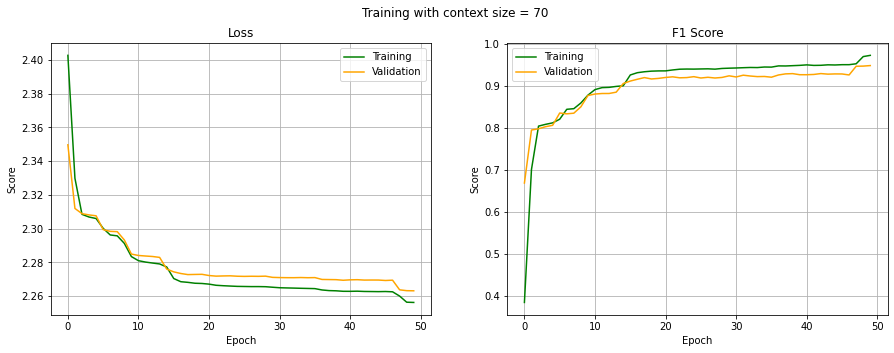

In [22]:
now = datetime.now(pytz.timezone("Asia/Ujung_Pandang"))
path_name = now.strftime("%m-%d-%Y_%H-%M-%S")
root_path = f"../../../logs/classifier/{hyperparams.context_size}_contexts/fold_0{hyperparams.fold}/{path_name}"
os.makedirs(root_path)

def looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric, n_epoch=hyperparams.n_epoch, patience=hyperparams.patience, monitor="loss"):    
    start_time = time()
    
    epoch_training_losses = []
    epoch_training_metric_scores = []
    epoch_val_losses = []
    epoch_val_metric_scores = []
    patience_counter = 0
    
    # Hyperparameters
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write(f"HYPERPARAMETERS\n")
        f.write(f"{'-' * 80}\n")
        for name, value in vars(hyperparams).items():
            f.write(f"{name}: {value}\n")
        
        f.write("\n\nTRAINING PROGRESS\n")
        f.write(f"{'-' * 80}\n")
    
    # Training Progress
    for epoch in range(1, n_epoch + 1):
        print(f"EPOCH-{epoch}")
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"EPOCH-{epoch}\n")
            f.write(f"Training Step\n")
            
        # Training Step
        print("Training Step")
        batch_training_losses, batch_training_metric_scores = training_step(train_dataloader, model, optimizer, criterion, train_metric, scheduler=None)
        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))

        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))
        epoch_training_losses.append(epoch_training_loss.item())

        epoch_training_metric_score = torch.mean(torch.FloatTensor(batch_training_metric_scores))
        epoch_training_metric_scores.append(epoch_training_metric_score.item())
        
        # Validation Step
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"\nValidation Step\n")
            
        print("\nValidation Step")
        batch_val_losses, batch_val_metric_scores = validation_step(val_dataloader, model, criterion, val_metric)
        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))

        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))
        epoch_val_losses.append(epoch_val_loss.item())

        epoch_val_metric_score = torch.mean(torch.FloatTensor(batch_val_metric_scores))
        epoch_val_metric_scores.append(epoch_val_metric_score.item())
        
        with open(f"{root_path}/training_history.txt", "a") as f:
            if monitor == "loss":
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_losses[-1] < epoch_training_losses[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
            else:
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_metric_scores[-1] > epoch_training_metric_scores[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗\n")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
                    
            print("=" * 80, end="\n\n")
            
            f.write(f"{'=' * 80}\n\n")
            
            if patience_counter == patience:
                print(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                
                f.write(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                break
        
        train_metric.reset()
        val_metric.reset()
        
    finish_time = time()
    
    # Training plot 
    fig, (ax_loss, ax_metric_score) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    fig.suptitle(f"Training with context size = {hyperparams.context_size}")

    ax_loss.set_title("Loss")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Score")
    ax_loss.plot(epoch_training_losses, "green", label="Training")
    ax_loss.plot(epoch_val_losses, "orange", label="Validation")
    ax_loss.legend()
    ax_loss.grid()

    ax_metric_score.set_title("F1 Score")
    ax_metric_score.set_xlabel("Epoch")
    ax_metric_score.set_ylabel("Score")
    ax_metric_score.plot(epoch_training_metric_scores, "green", label="Training")
    ax_metric_score.plot(epoch_val_metric_scores, "orange", label="Validation")
    ax_metric_score.legend()
    ax_metric_score.grid()

    plt.savefig(f"{root_path}/training_plot.jpg", dpi=200)                        
    
    print("TRAINING SUMMARY")
    name_best_training_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_training_metric = f"Best {str(train_metric).split('(')[0]} validation".ljust(34)
    name_best_validation_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_validation_metric = f"Best {str(val_metric).split('(')[0]} validation".ljust(34)
    name_training_time = f"Training duration".ljust(34)
    name_training_date = f"Training date".ljust(34)
    
    print(f"{name_best_training_loss}: {best_training_loss:.4f}")
    print(f"{name_best_validation_loss}: {best_val_loss:.4f}")
    print(f"{name_best_training_metric}: {best_training_metric:.4f}")
    print(f"{name_best_validation_metric}: {best_val_metric:.4f}")
    print(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.")
    print(f"{name_training_date}: {now}")
    
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write("\nTRAINING SUMMARY\n")
        f.write(f"{'-' * 80}\n")
        f.write(f"{name_best_training_loss}: {best_training_loss:.4f}\n")
        f.write(f"{name_best_validation_loss}: {best_val_loss:.4f}\n")
        f.write(f"{name_best_training_metric}: {best_training_metric:.4f}\n")
        f.write(f"{name_best_validation_metric}: {best_val_metric:.4f}\n")
        f.write(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.\n")
        f.write(f"{name_training_date}: {now}\n")
    
    # Save epoch losses, epoch metric scores, model, state dict, and oov embedding dict
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_training_losses
    }).to_csv(f"{root_path}/training_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_training_metric_scores
    }).to_csv(f"{root_path}/training_metric_scores.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_val_losses
    }).to_csv(f"{root_path}/val_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_val_metric_scores
    }).to_csv(f"{root_path}/val_metric_scores.csv", index=False)    
    
    filename_model_params = f"{root_path}/model_params.pth"
    torch.save(best_state_dict, filename_model_params)
    
    return epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores

epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores = looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric)

## End Training

# Evaluation

In [23]:
def evaluation(dataloader, model, criterion, metric):
    model.eval()
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)
            pred = rearrange(prob.argmax(dim=1).reshape(feature.shape[0], len(dataloader.dataset)), "s n -> n s")

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob.argmax(dim=1), actual_label.to(hyperparams.device))
            metric_score = metric.compute()

    return loss, metric_score, pred

train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset))
val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset))
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
train_loss, train_f1_score, train_pred_label = evaluation(train_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_loss, val_f1_score, val_pred_label = evaluation(val_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
test_loss, test_f1_score, test_pred_label = evaluation(test_dataloader, model, criterion, metric)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9719, device='cuda:0'),
 tensor(0.9492, device='cuda:0'),
 tensor(0.9486, device='cuda:0'))

In [25]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9719, device='cuda:0'),
 tensor(0.9492, device='cuda:0'),
 tensor(0.9486, device='cuda:0'))

## Heatmap

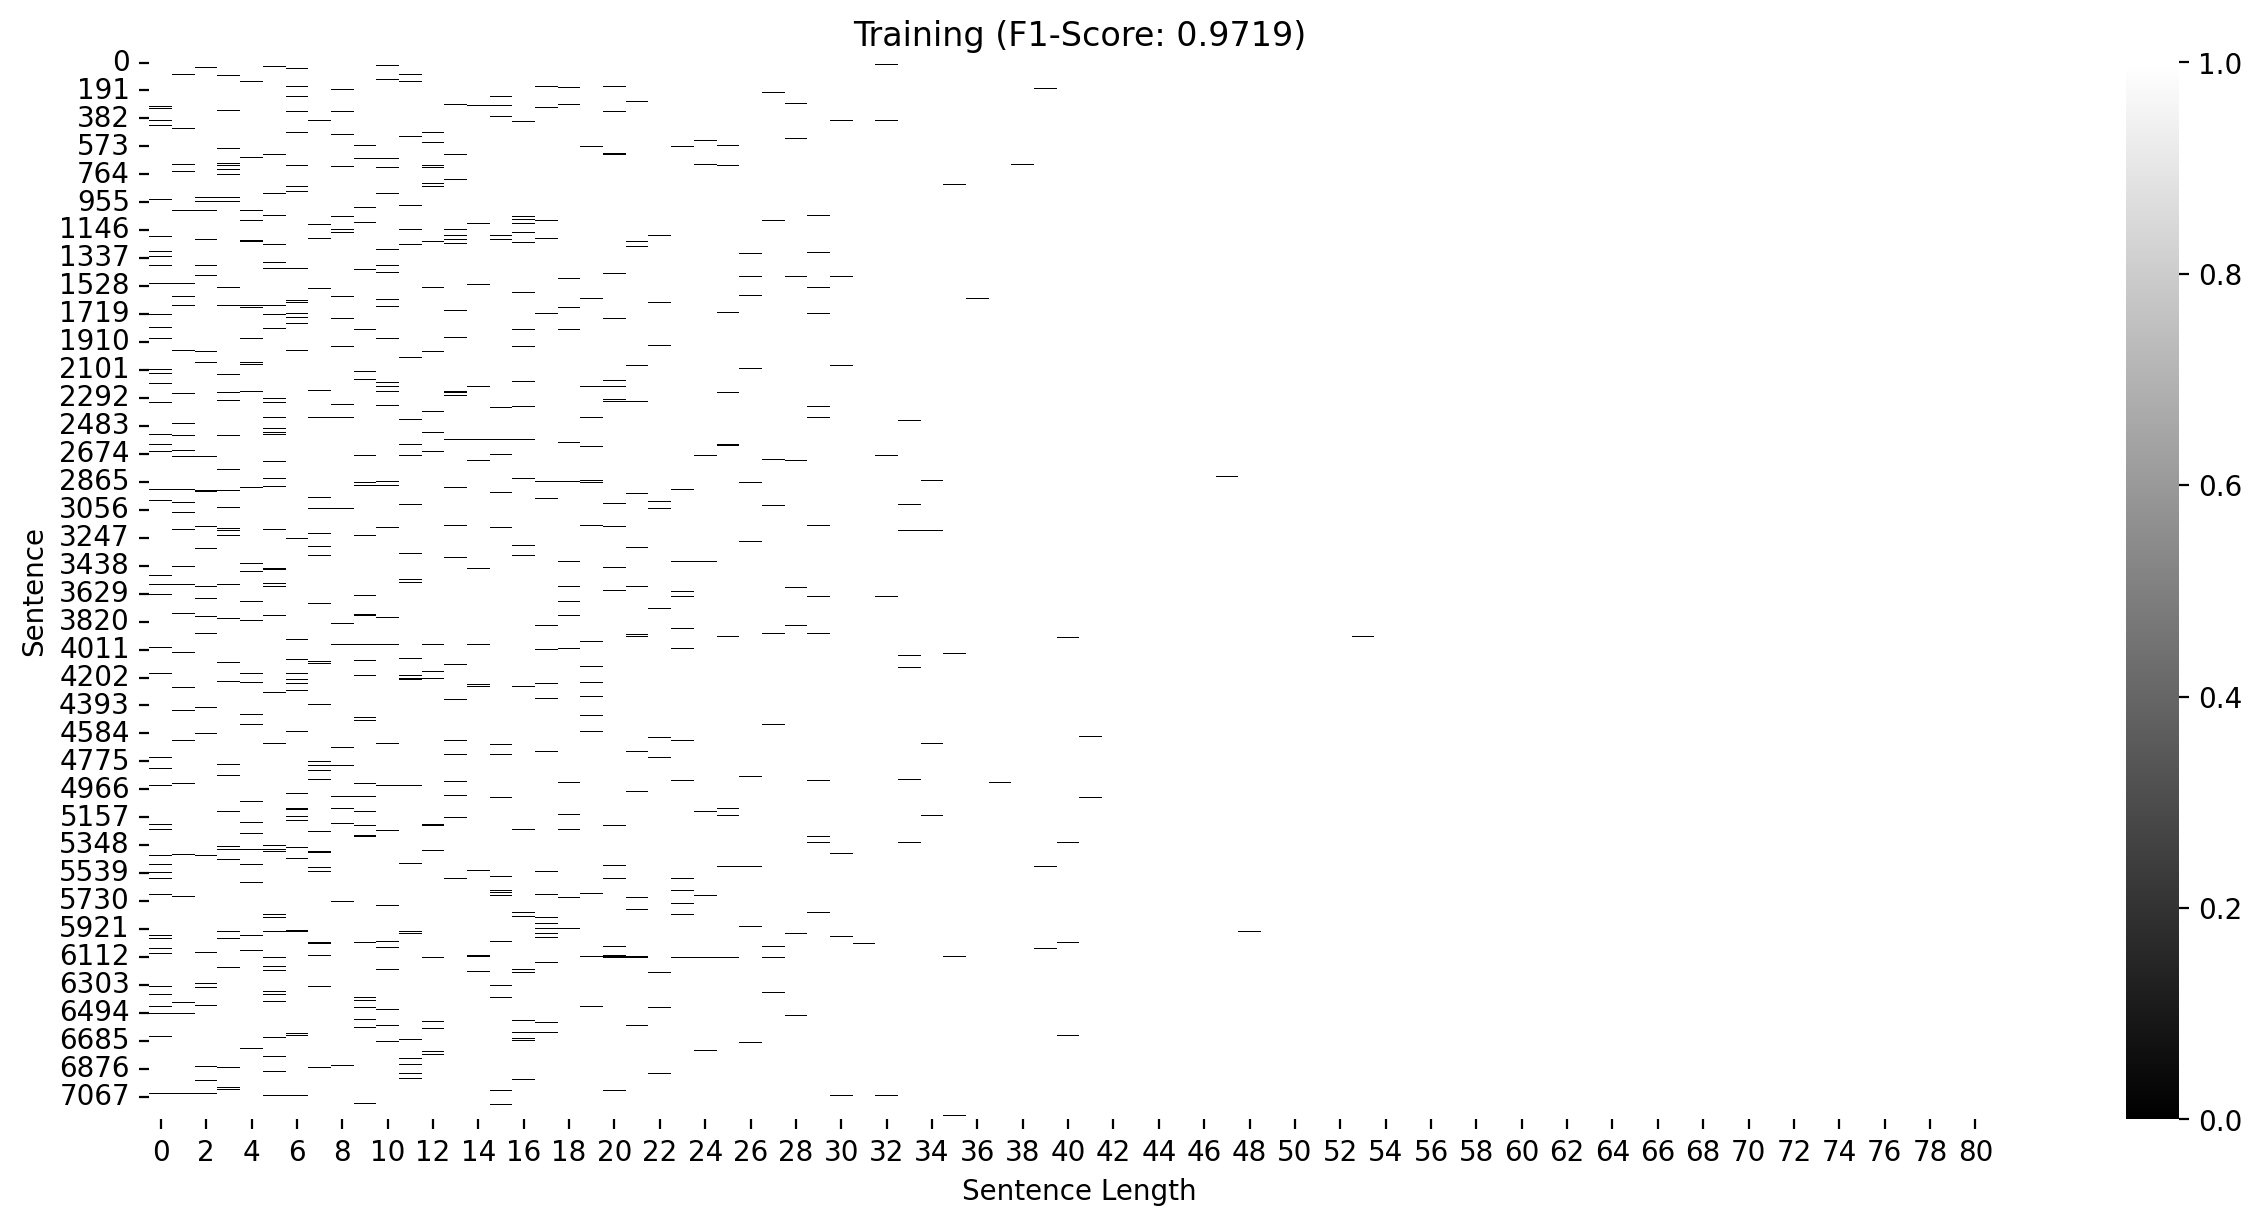

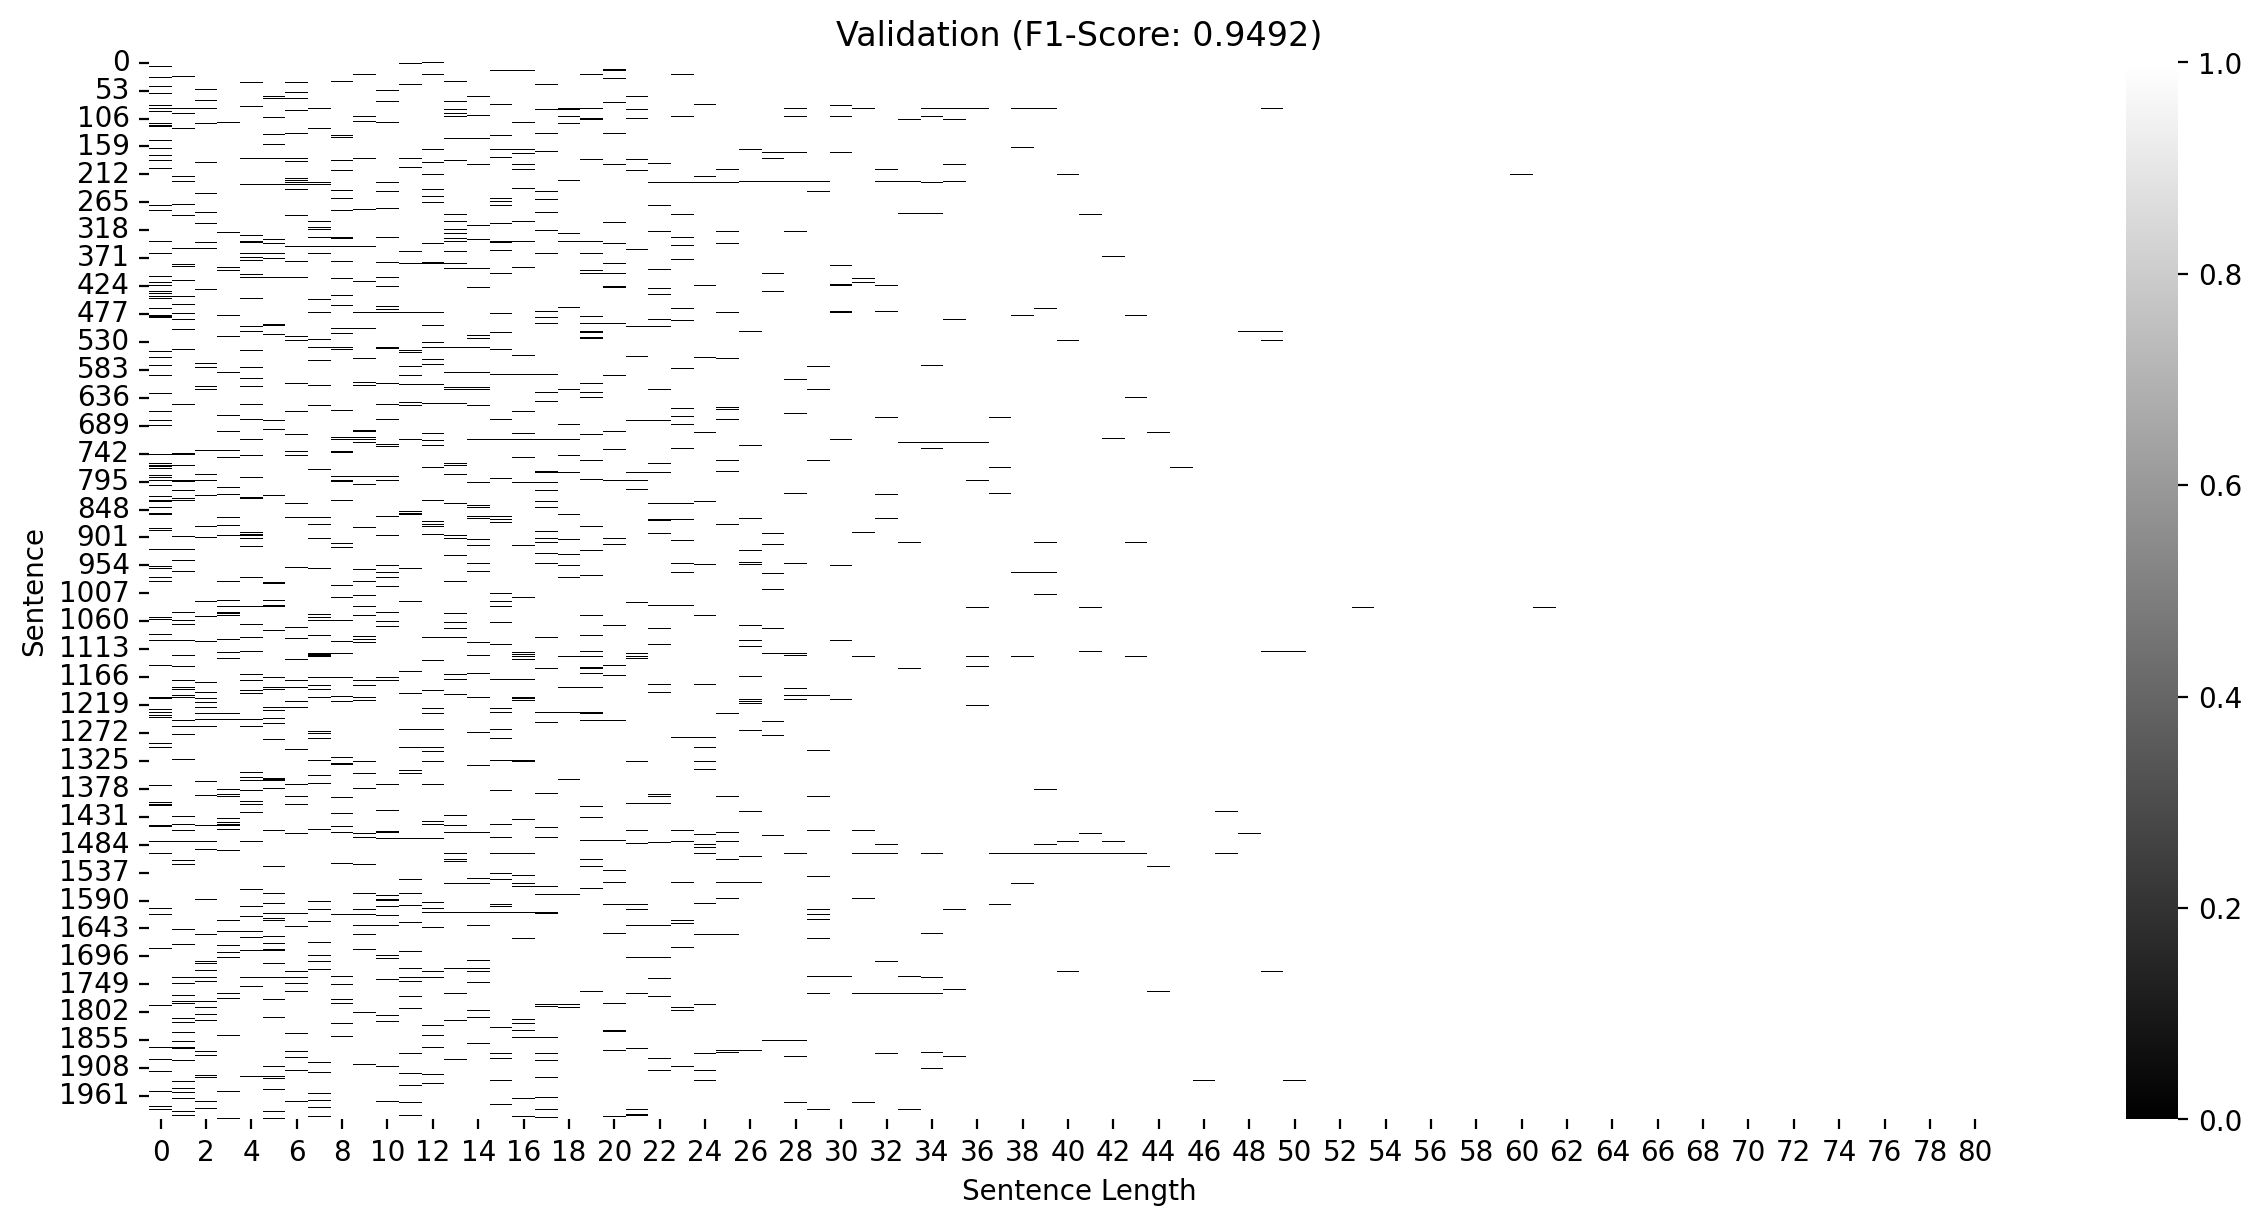

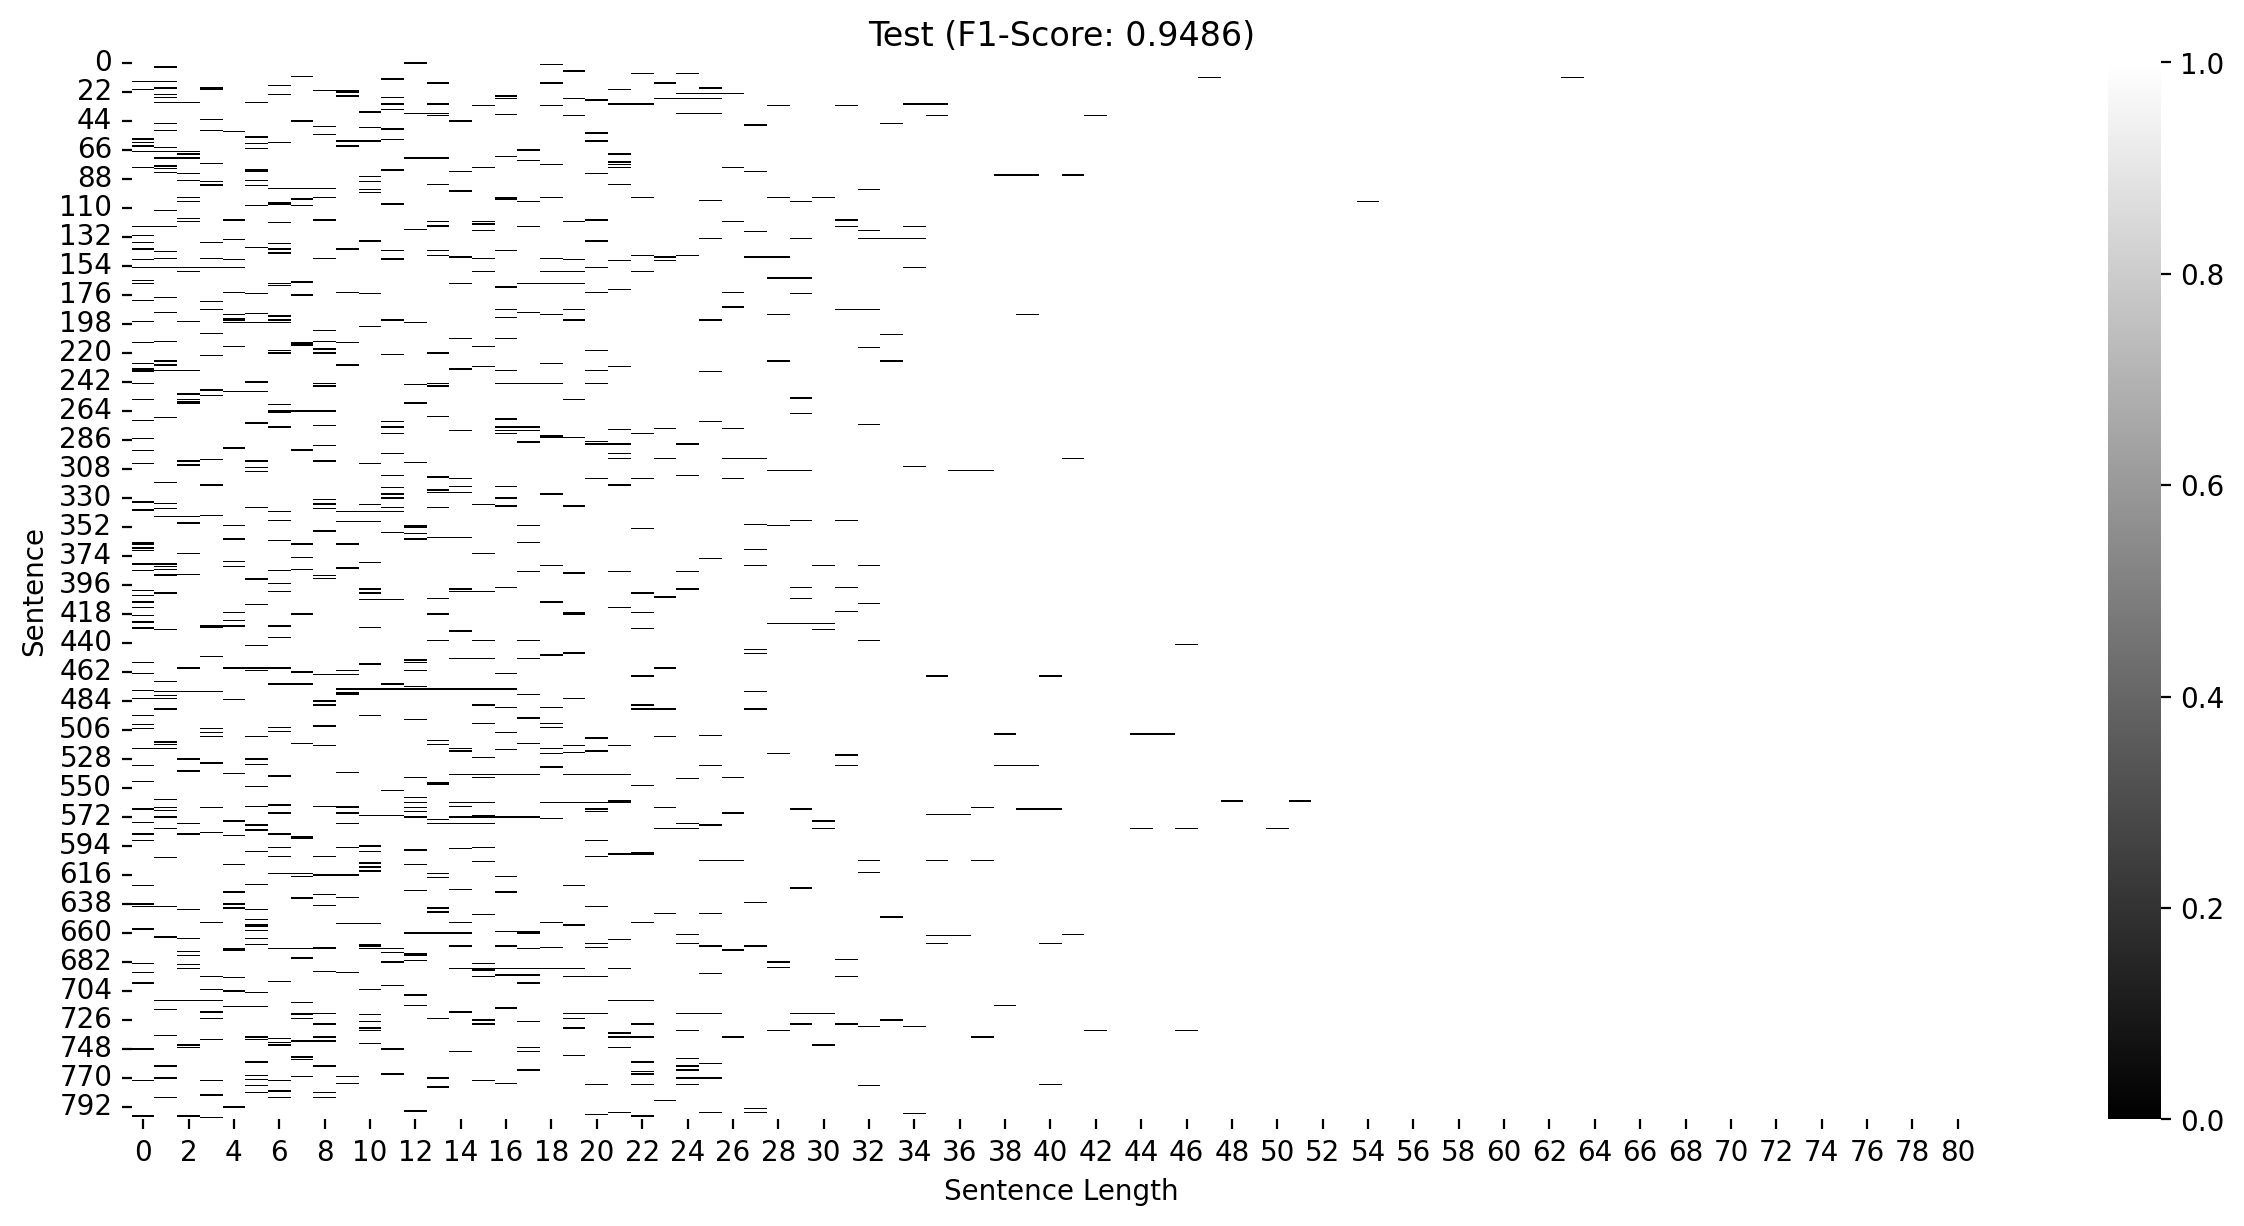

In [26]:
import seaborn as sns

def viz_evaluation(pred_label, actual_label, title):
    plt.figure(figsize=(15, 7), dpi=200)
    sns.heatmap(pred_label.detach().cpu() == actual_label, cbar=True, cmap="binary_r")
    plt.xlabel("Sentence Length")
    plt.ylabel("Sentence")
    plt.title(title)
    plt.savefig(f"{root_path}/heatmap_{title.lower()}.jpg", dpi=200)
    plt.show()

train_actual_label = train_dataloader.dataset.tensors[1]
val_actual_label = val_dataloader.dataset.tensors[1]
test_actual_label = test_dataloader.dataset.tensors[1]

viz_evaluation(train_pred_label, train_actual_label, f"Training (F1-Score: {(train_f1_score):.4f})")
viz_evaluation(val_pred_label, val_actual_label, f"Validation (F1-Score: {(val_f1_score):.4f})")
viz_evaluation(test_pred_label, test_actual_label, f"Test (F1-Score: {(test_f1_score):.4f})")

## Confusion Matrix

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 72 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 120 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)


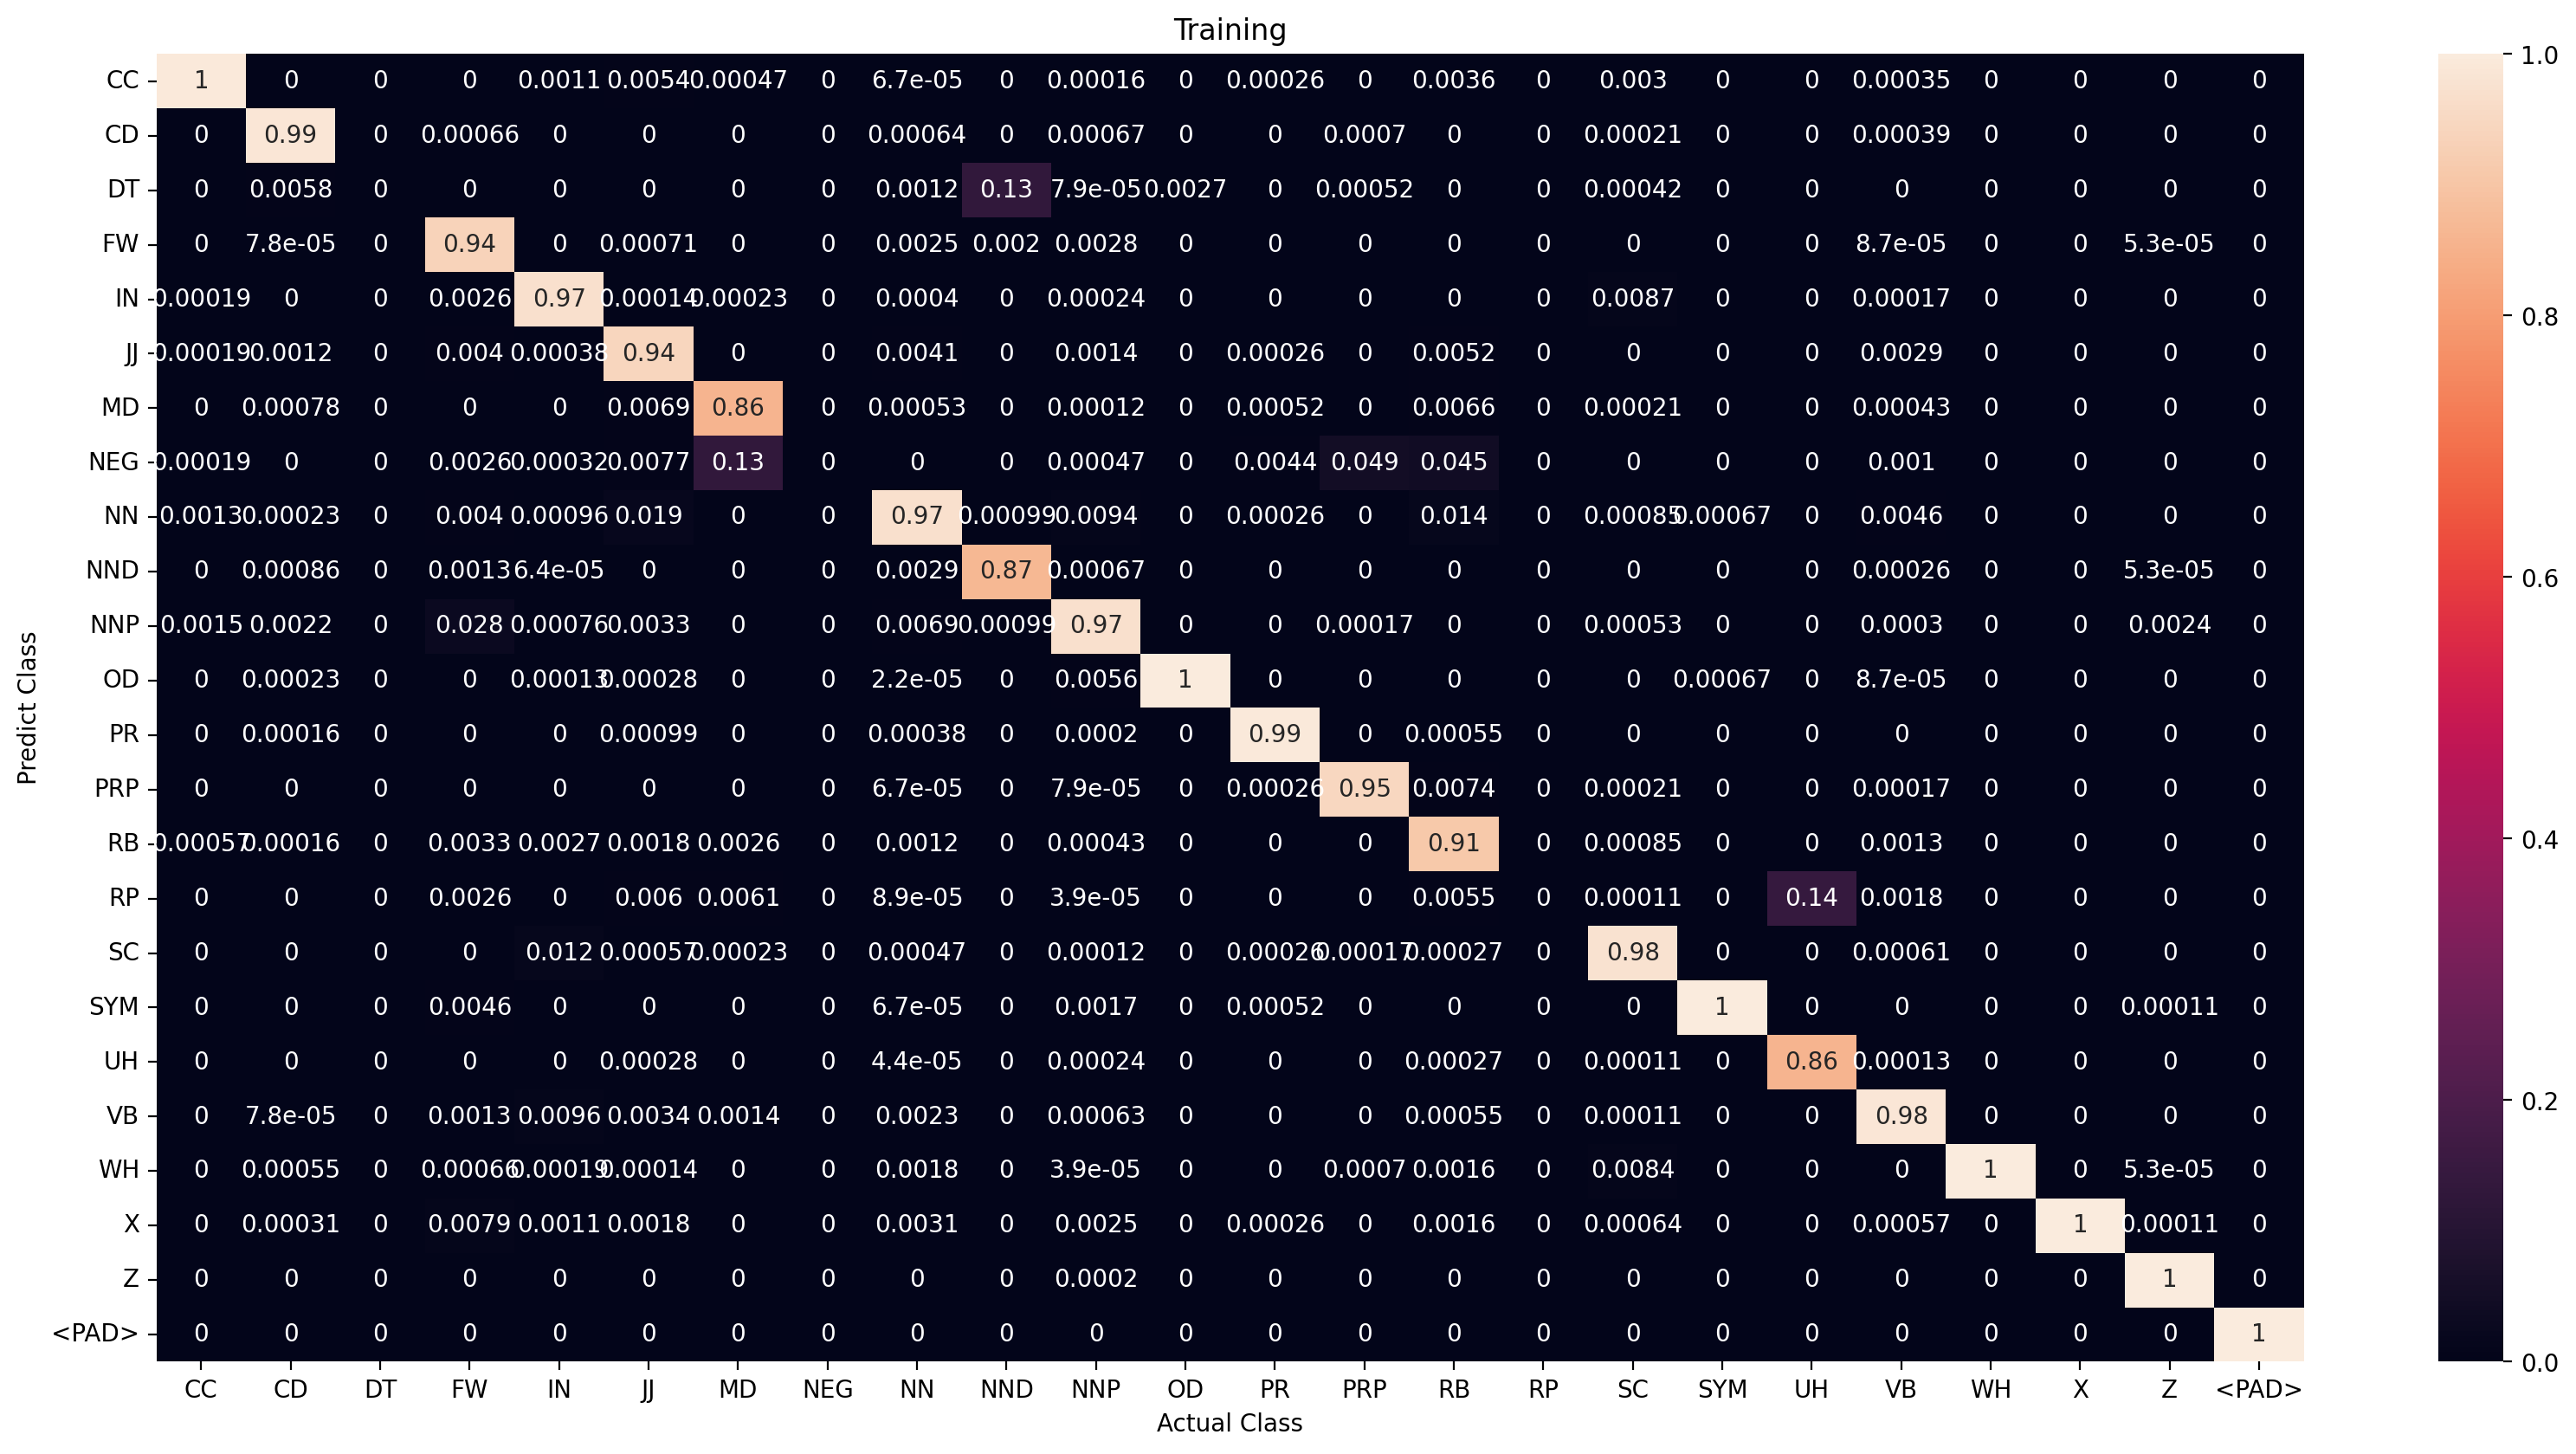

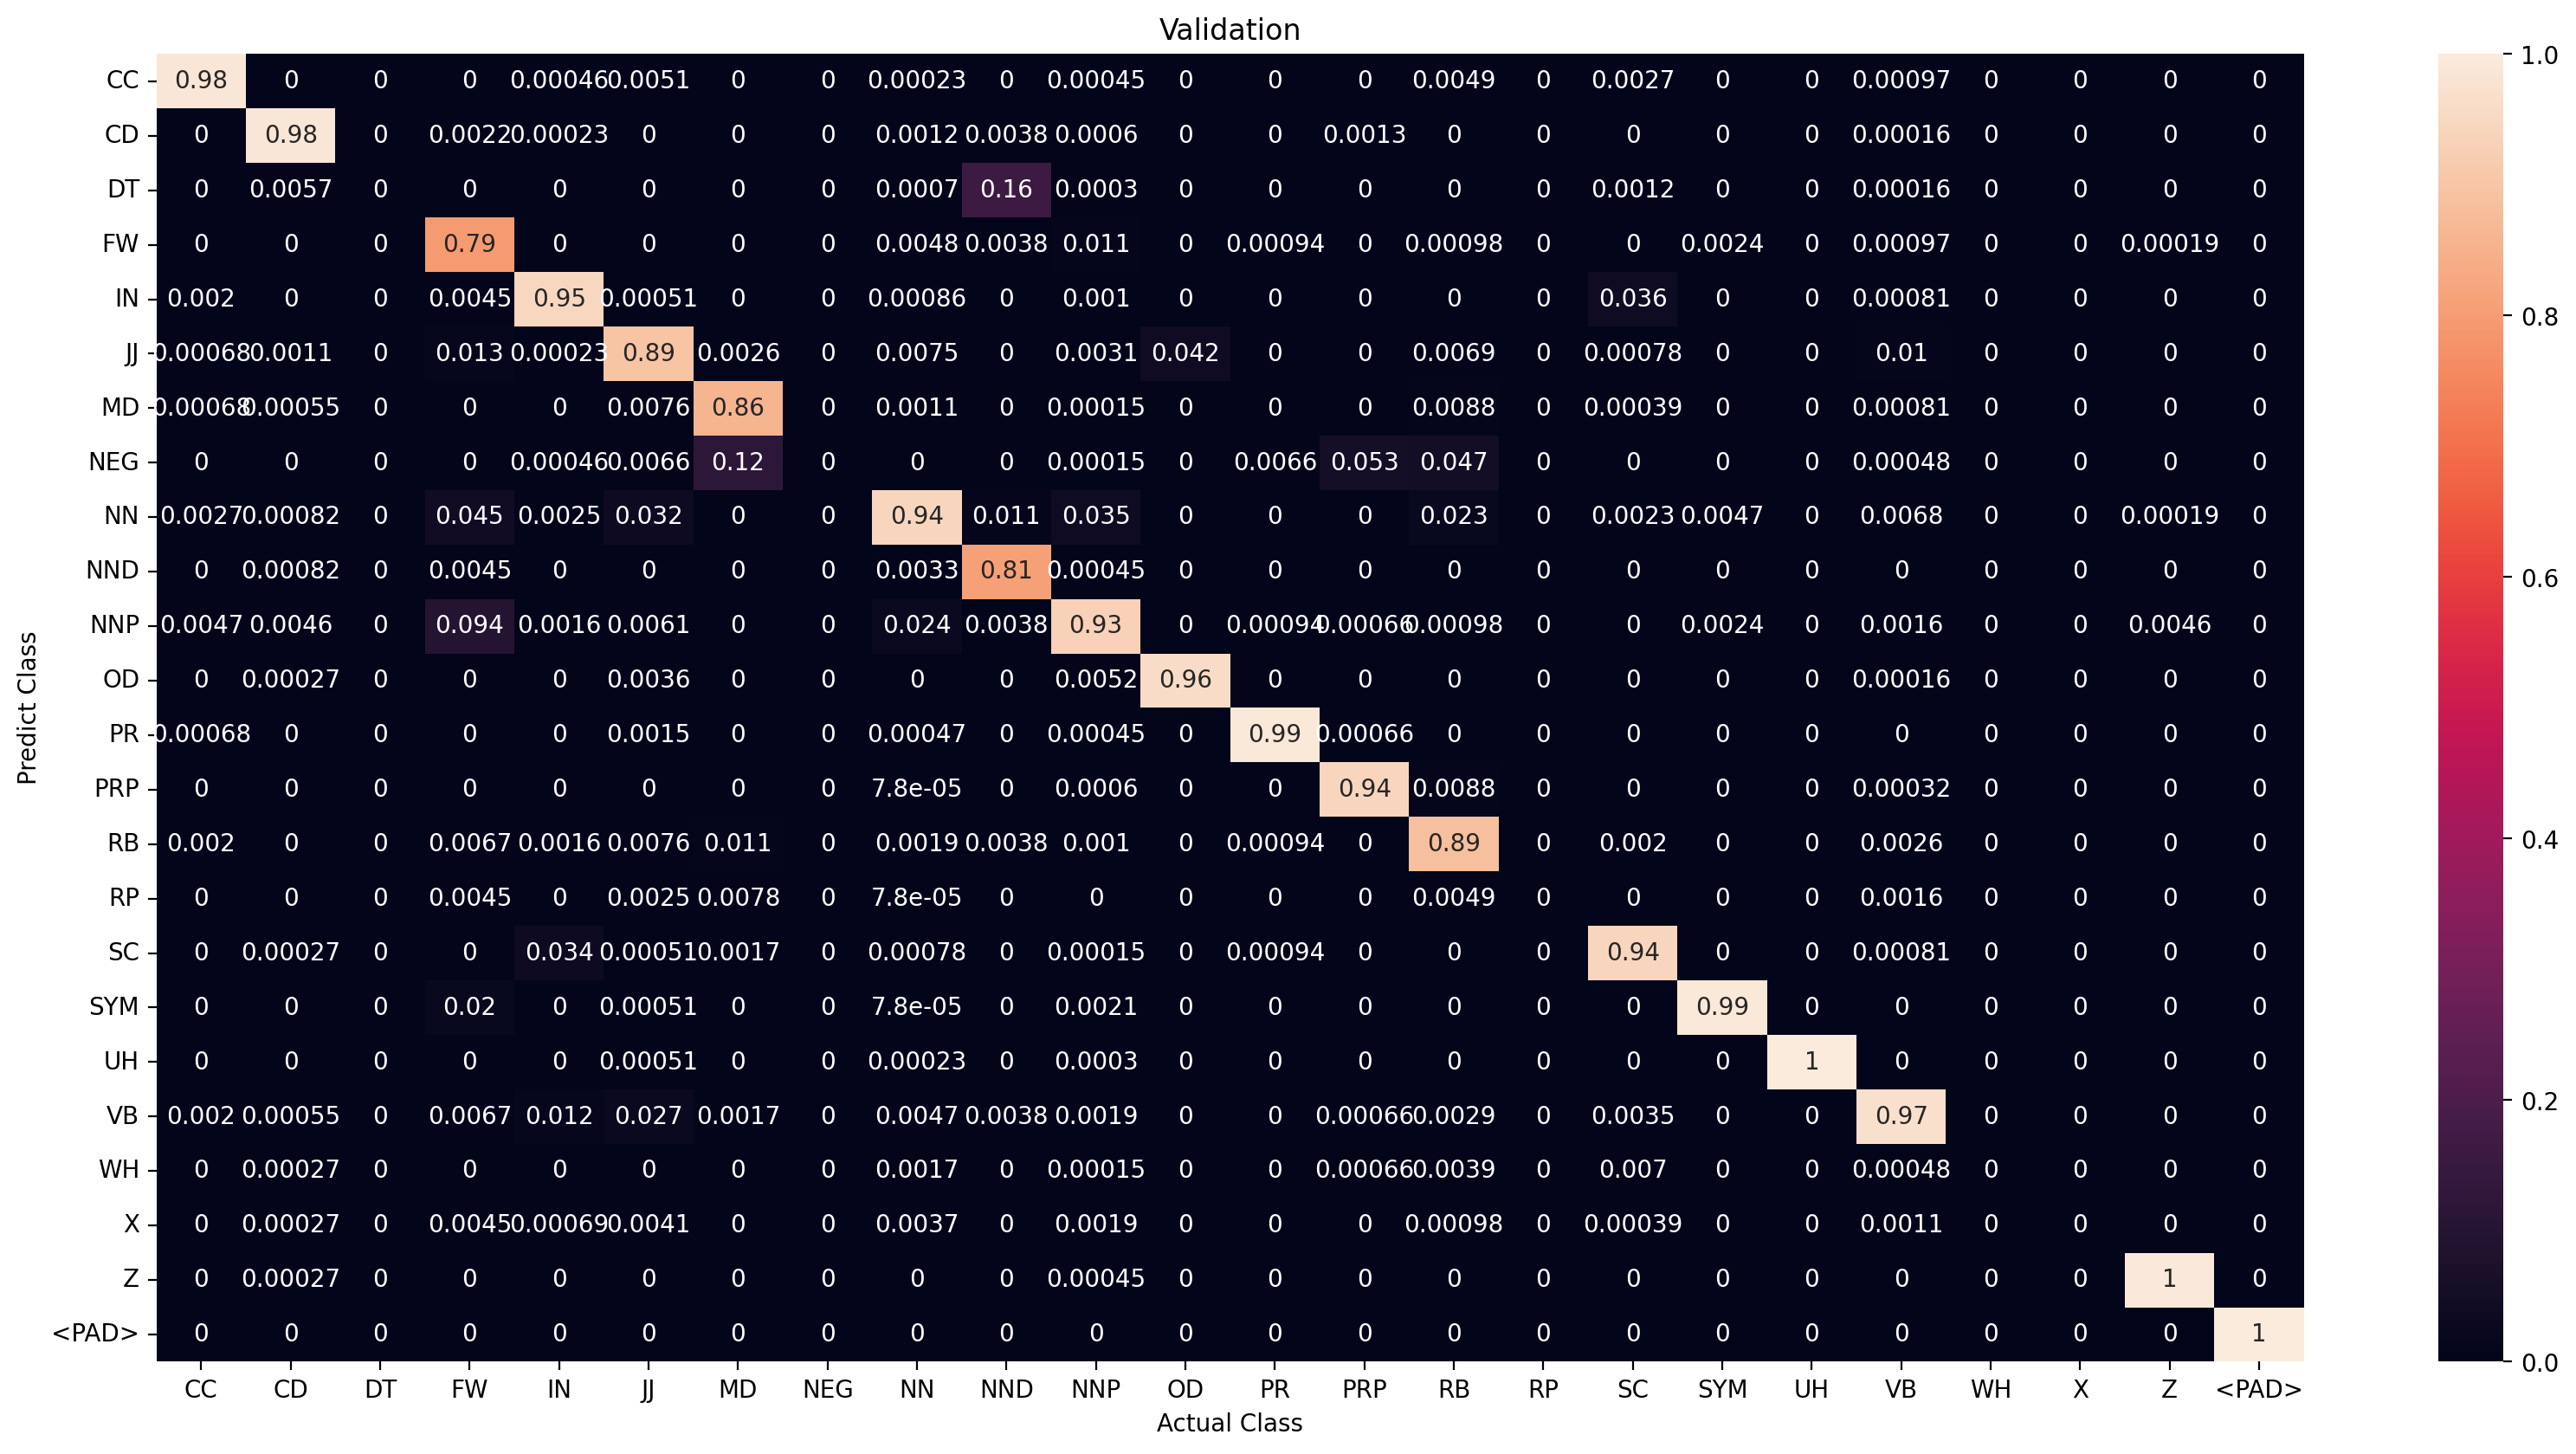

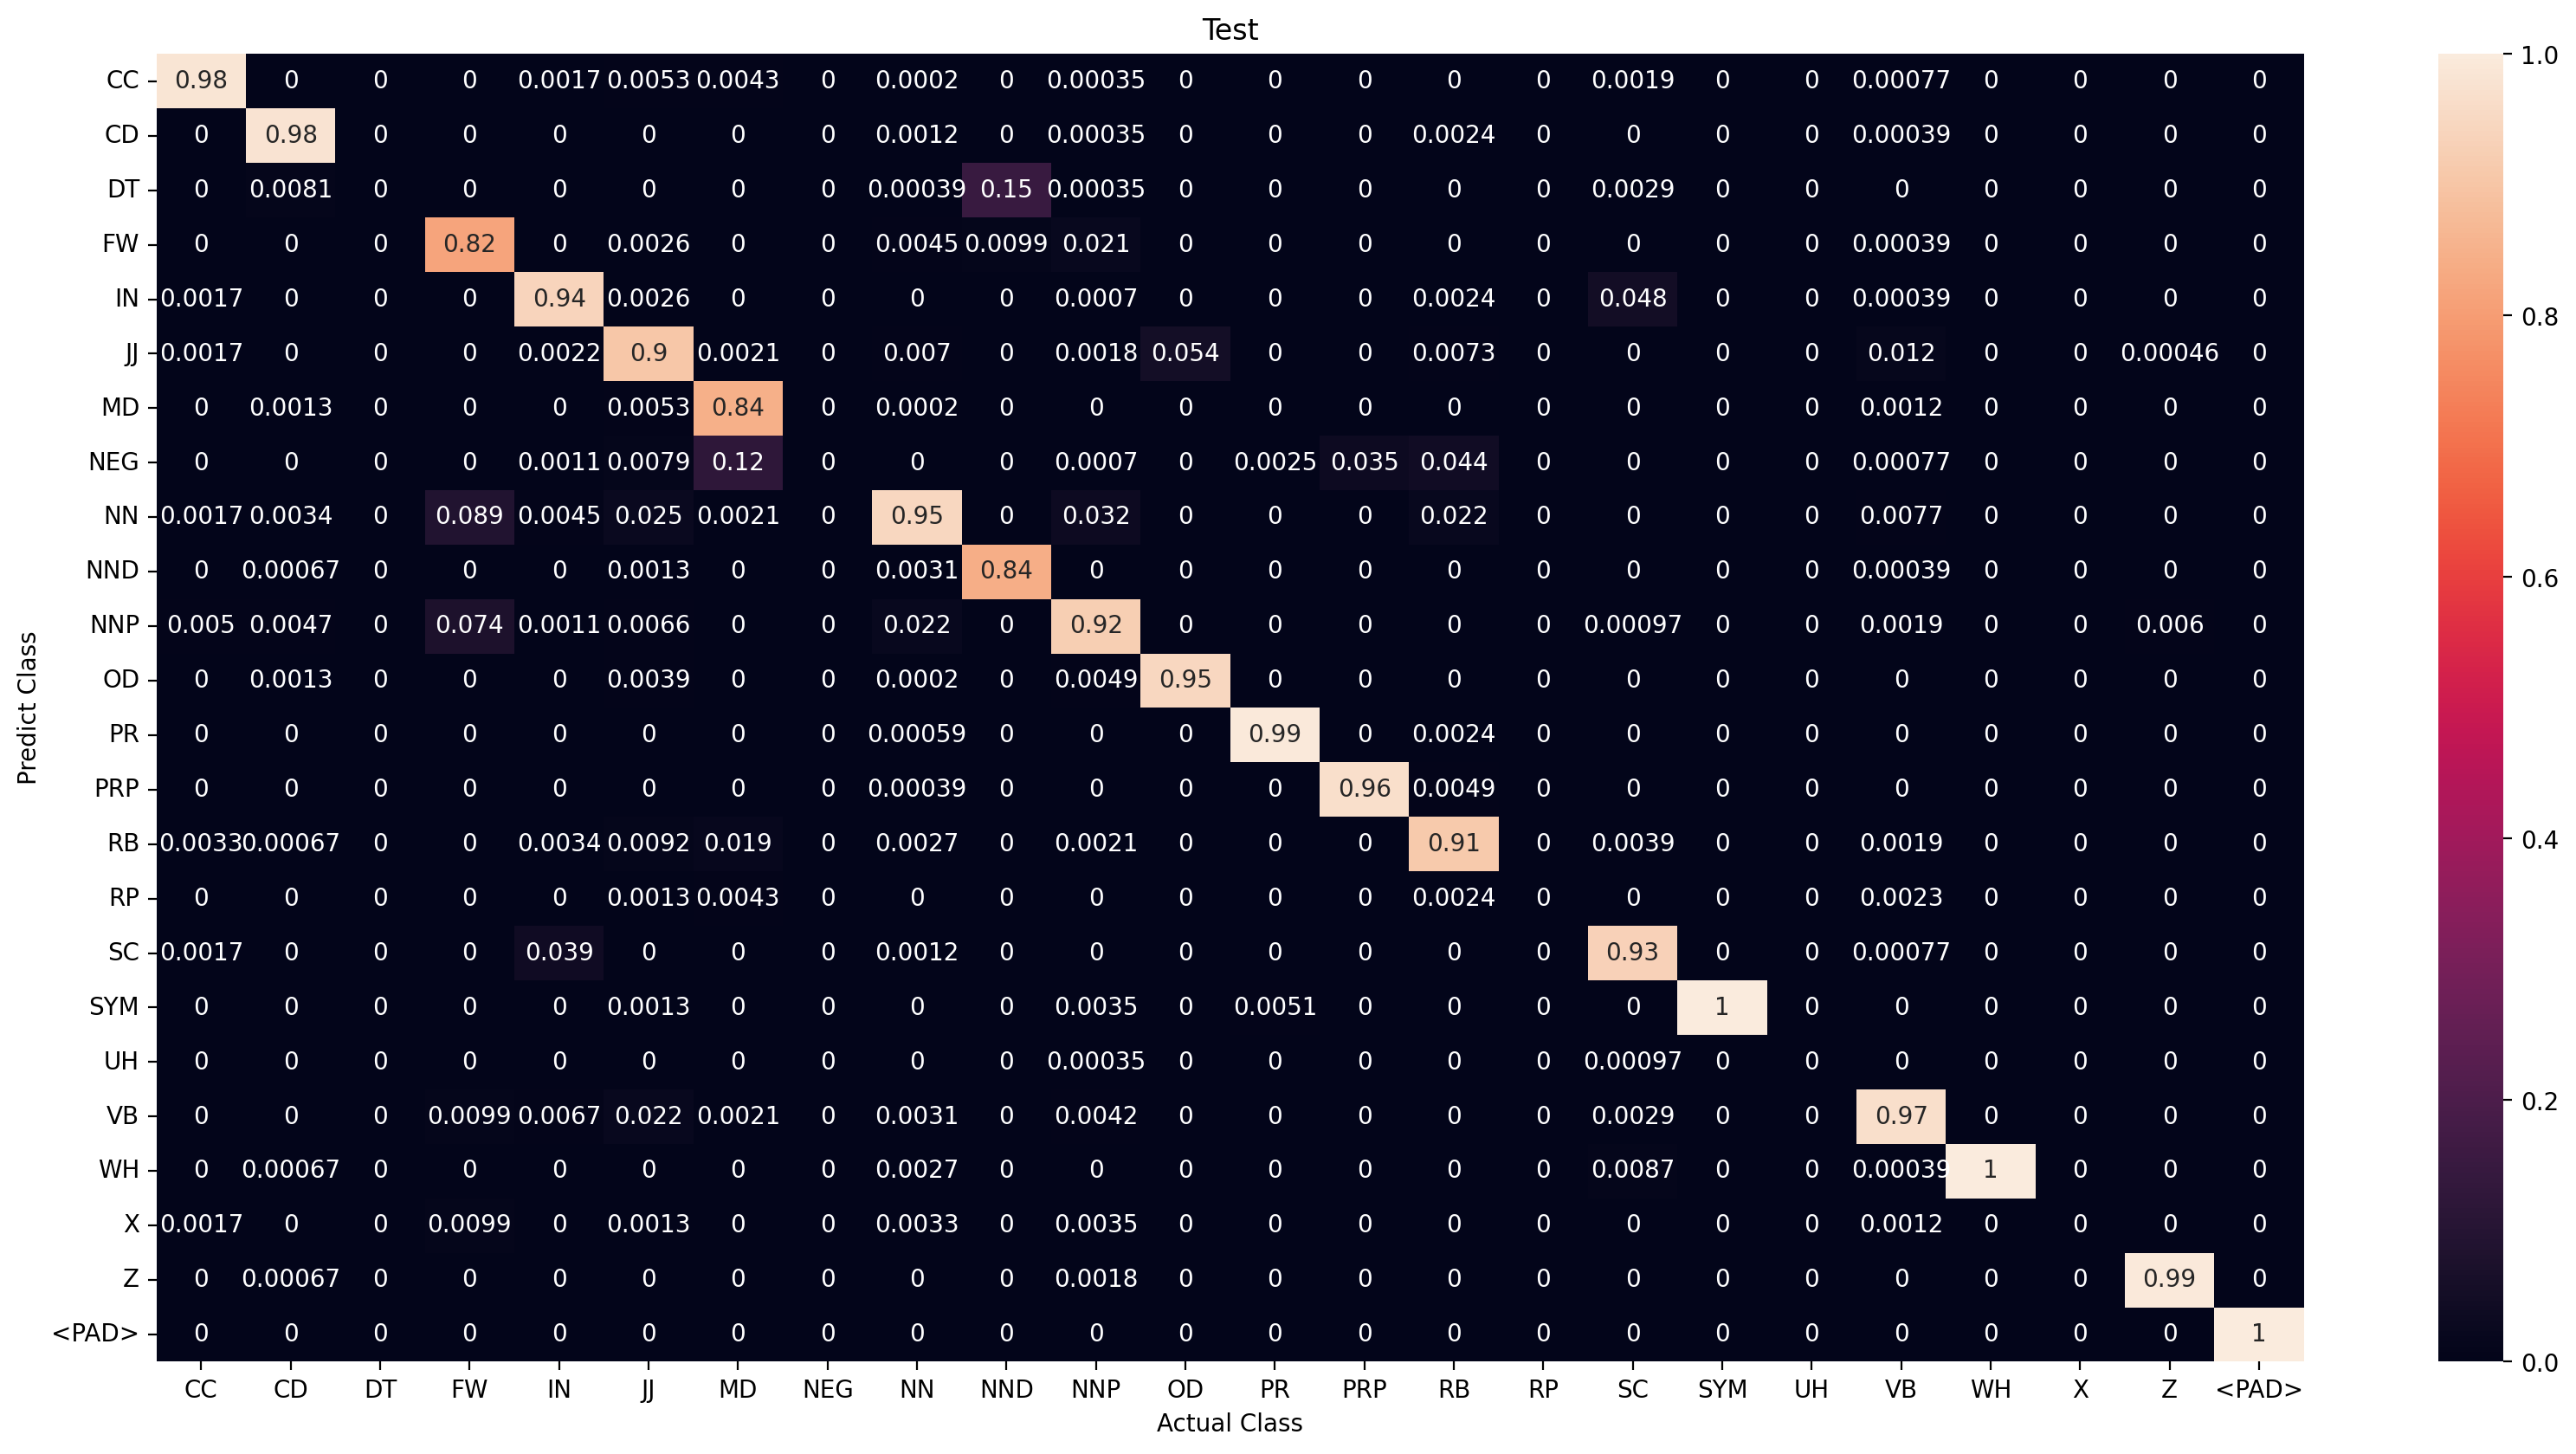

In [27]:
def confusion_matrix(pred_class, actual_class, title, normalize=None):
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize=normalize)
    plt.figure(figsize=(20, 10), dpi=200)
    sns.heatmap(conf_mat(pred_class.detach().cpu(), actual_class), annot=True, fmt=".2g", xticklabels=list(label_to_idx.keys()), yticklabels=list(label_to_idx.keys()));
    plt.yticks(rotation=0)
    plt.title(title)
    plt.xlabel("Actual Class")
    plt.ylabel("Predict Class")
    plt.savefig(f"{root_path}/conf_matrix_{title.lower()}.jpg", dpi=200)

confusion_matrix(train_pred_label, train_actual_label, "Training", "pred")
confusion_matrix(val_pred_label,val_actual_label, "Validation", "pred")
confusion_matrix(test_pred_label, test_actual_label, "Test", "pred")

## Prediction Table

In [28]:
def number_wrong_pred_each_class(pred_class, actual_class):
    classes, count_class = actual_class.flatten().unique(return_counts=True)
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize="none")
    correct_pred_count_class = conf_mat(pred_class.detach().cpu(), actual_class).diag()
    
    correct_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (correct_pred_count_class))}
    wrong_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (count_class - correct_pred_count_class))}
    
    return correct_pred, wrong_pred

correct_pred, wrong_pred = number_wrong_pred_each_class(train_pred_label, train_actual_label)
print(f"| {'Number class'.ljust(14)} | {'Correct prediction'.ljust(12)} | {'Wrong prediction'.ljust(12)} |")
for (label_correct_pred, count_correct_pred), (label_wrong_pred, count_wrong_pred) in zip(correct_pred.items(), wrong_pred.items()):
    print(f"| {str(label_correct_pred).ljust(6)}: {str(count_correct_pred + count_wrong_pred).ljust(7)}| {label_correct_pred.ljust(6)}: {str(count_correct_pred).ljust(10)} | {label_wrong_pred.ljust(6)}: {str(count_wrong_pred).ljust(8)} |")

| Number class   | Correct prediction | Wrong prediction |
| CC    : 5346   | CC    : 5232       | CC    : 114      |
| CD    : 12730  | CD    : 12668      | CD    : 62       |
| DT    : 269    | DT    : 0          | DT    : 269      |
| FW    : 1614   | FW    : 1421       | FW    : 193      |
| IN    : 15342  | IN    : 15225      | IN    : 117      |
| JJ    : 6981   | JJ    : 6643       | JJ    : 338      |
| MD    : 3799   | MD    : 3675       | MD    : 124      |
| NEG   : 1118   | NEG   : 0          | NEG   : 1118     |
| NN    : 44369  | NN    : 43798      | NN    : 571      |
| NND   : 1047   | NND   : 877        | NND   : 170      |
| NNP   : 25175  | NNP   : 24692      | NNP   : 483      |
| OD    : 524    | OD    : 370        | OD    : 154      |
| PR    : 3880   | PR    : 3847       | PR    : 33       |
| PRP   : 5471   | PRP   : 5432       | PRP   : 39       |
| RB    : 3477   | RB    : 3300       | RB    : 177      |
| RP    : 141    | RP    : 0          | RP    : 141     

In [29]:
train_actual_label[308], train_pred_label[308]

(tensor([ 8,  3, 12, 19,  8,  8,  8, 16, 19,  4, 10,  8, 10,  0,  4,  1,  8,  8,
          8,  5,  4,  8, 10,  0, 10, 10, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23]),
 tensor([ 8,  8, 12, 19,  8,  8,  5, 16, 19,  4, 10,  8, 10,  0,  4,  1,  8,  8,
          8,  5,  4,  8, 10,  0, 10, 10, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23], device='cuda:0'))

In [30]:
train_actual_label[308] == train_pred_label[308].detach().cpu()

tensor([ True, False,  True,  True,  True,  True, False,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True])

## OOV prediction is correct 

In [31]:
def oov_flag_token(sentences, max_seq_len=hyperparams.max_seq_len):
    sent_copy = deepcopy(sentences)
    sent = []
    oov_flag = []
    
    for sentence in tqdm(sent_copy):
        for token in sentence:
            sent.append(token[2])
        
        for _ in range(max_seq_len- len(sentence)):
            sent.append(False)
        
        oov_flag.append(sent)
        sent = []
        
    return np.array(oov_flag)

train_oov_flag = oov_flag_token(train_sentences, max_seq_len=hyperparams.max_seq_len)
val_oov_flag = oov_flag_token(val_sentences, max_seq_len=hyperparams.max_seq_len)
test_oov_flag = oov_flag_token(test_sentences, max_seq_len=hyperparams.max_seq_len)

def pencentage_oov_pred_correct(pred_oov_flag, oov_flag_tensor):
    oov_correct_counter = 0
    oov_wrong_counter = 0

    for pred, oov_label in tqdm(zip(pred_oov_flag, oov_flag_tensor)):
        if pred == True and oov_label == True:
            oov_correct_counter += 1
        elif pred == False and oov_label == True:
            oov_wrong_counter += 1
        else:
            continue
            
    return oov_correct_counter, oov_wrong_counter

train_pred_oov_flag = (train_actual_label == train_pred_label.detach().cpu()).flatten()
val_pred_oov_flag = (val_actual_label == val_pred_label.detach().cpu()).flatten()
test_pred_oov_flag = (test_actual_label == test_pred_label.detach().cpu()).flatten()
train_oov_flag_tensor = torch.tensor(train_oov_flag).flatten()
val_oov_flag_tensor = torch.tensor(val_oov_flag).flatten()
test_oov_flag_tensor = torch.tensor(test_oov_flag).flatten()

train_oov_correct_counter, train_oov_wrong_counter = pencentage_oov_pred_correct(train_pred_oov_flag, train_oov_flag_tensor)
val_oov_correct_counter, val_oov_wrong_counter = pencentage_oov_pred_correct(val_pred_oov_flag, val_oov_flag_tensor)
test_oov_correct_counter, test_oov_wrong_counter = pencentage_oov_pred_correct(test_pred_oov_flag, test_oov_flag_tensor)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [32]:
def print_percentage_pred_oov(title, oov_correct_counter, oov_wrong_counter):
    print(f"{title}")
    print(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}")
    print(f"Correct prediction          : {oov_correct_counter}")
    print(f"Wrong prediction            : {oov_wrong_counter}")
    print(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n")
    
    with open(f"{root_path}/oov_summary.txt", "a") as f:
        f.write(f"{title}\n")
        f.write(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}\n")
        f.write(f"Correct prediction          : {oov_correct_counter}\n")
        f.write(f"Wrong prediction            : {oov_wrong_counter}\n")
        f.write(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n\n")

In [33]:
print_percentage_pred_oov("Training", train_oov_correct_counter, train_oov_wrong_counter)
print_percentage_pred_oov("Validation", val_oov_correct_counter, val_oov_wrong_counter)
print_percentage_pred_oov("Test", test_oov_correct_counter, test_oov_wrong_counter)

Training
Number OOV token            : 11806
Correct prediction          : 11267
Wrong prediction            : 539
Percentage correct oov pred : 95.43452481788921

Validation
Number OOV token            : 3366
Correct prediction          : 3014
Wrong prediction            : 352
Percentage correct oov pred : 89.54248366013073

Test
Number OOV token            : 1390
Correct prediction          : 1253
Wrong prediction            : 137
Percentage correct oov pred : 90.14388489208633



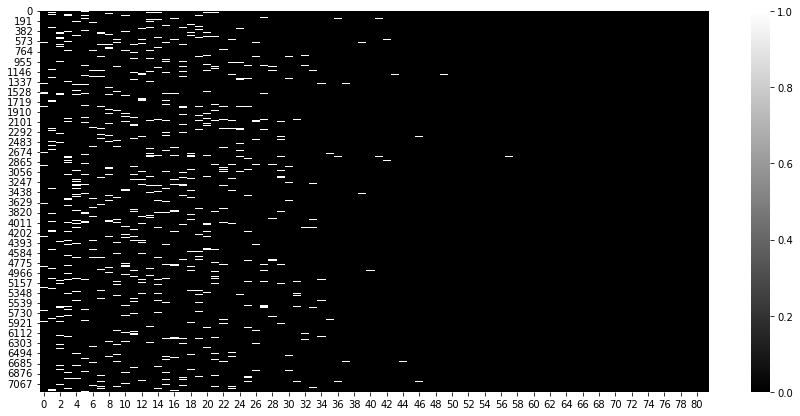

In [34]:
plt.figure(figsize=(15, 7))
sns.heatmap(train_oov_flag, cmap=plt.cm.binary_r);

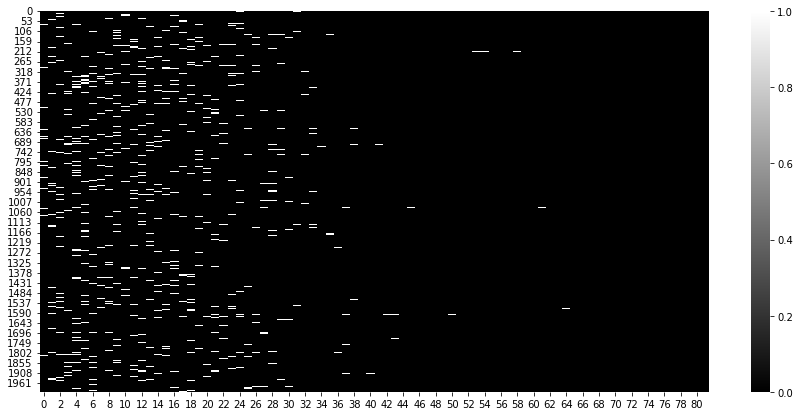

In [35]:
plt.figure(figsize=(15, 7))
sns.heatmap(val_oov_flag, cmap=plt.cm.binary_r);

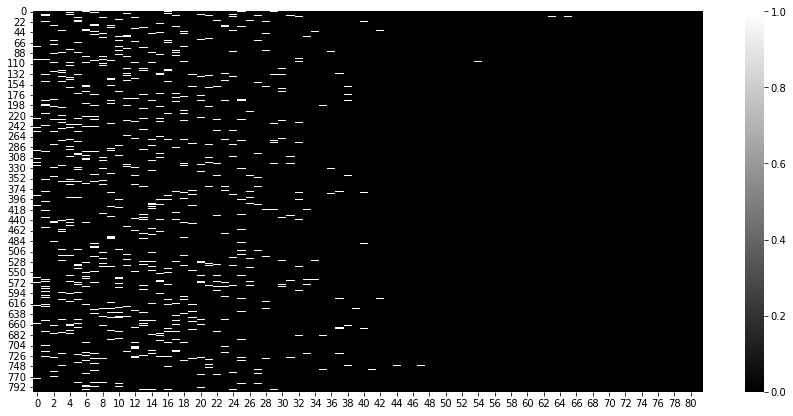

In [36]:
plt.figure(figsize=(15, 7))
sns.heatmap(test_oov_flag, cmap=plt.cm.binary_r);